In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec 
from sklearn.cluster import KMeans
from scipy.stats import spearmanr

In [58]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv', encoding = 'CP949')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [59]:
train

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  \
0         1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0   
1         1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0   
2         1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0   
3         1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0   
4         1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0   
...                 ...   ...          ...    ...      ...      ...    ...   
203995  100_20220824 19   100  20220824 19   23.1      NaN      0.9   86.0   
203996  100_20220824 20   100  20220824 20   22.4      NaN      1.3   86.0   
203997  100_20220824 21   100  20220824 21   21.3      NaN      1.0   92.0   
203998  100_20220824 22   100  20220824 22   21.0      NaN      0.3   94.0   
203999  100_20220824 23   100  20220824 23   20.7      NaN      0.1   95.0   

        일조(hr)  일사(MJ/m2)  전력소비량(kWh)  
0          NaN        NaN     1085.28  
1          NaN        NaN     1047.36  
2          NaN        NaN      974.88  
3          NaN        NaN      953.76  
4          NaN        NaN      986.40  
...        ...        ...         ...  
203995     0.5        NaN      881.04  
203996     0.0        NaN      798.96  
203997     NaN        NaN      825.12  
203998     NaN        NaN      640.08  
203999     NaN        NaN      540.24  

[204000 rows x 10 columns]

In [60]:
train1 = train.copy()
train1['일시'] = pd.to_datetime(train['일시'])

In [61]:
train1 = train1.drop(columns = 'num_date_time')

In [62]:
train1['시간'] = train1['일시'].dt.hour
train1['요일'] = train1['일시'].dt.weekday
train1['날짜'] = train1['일시'].dt.date
train1['일'] = train1['일시'].dt.day
train1['월'] = train1['일시'].dt.month
train1['연도'] = train1['일시'].dt.year
train1


건물번호                  일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0          1 2022-06-01 00:00:00   18.6      NaN      0.9   42.0     NaN   
1          1 2022-06-01 01:00:00   18.0      NaN      1.1   45.0     NaN   
2          1 2022-06-01 02:00:00   17.7      NaN      1.5   45.0     NaN   
3          1 2022-06-01 03:00:00   16.7      NaN      1.4   48.0     NaN   
4          1 2022-06-01 04:00:00   18.4      NaN      2.8   43.0     NaN   
...      ...                 ...    ...      ...      ...    ...     ...   
203995   100 2022-08-24 19:00:00   23.1      NaN      0.9   86.0     0.5   
203996   100 2022-08-24 20:00:00   22.4      NaN      1.3   86.0     0.0   
203997   100 2022-08-24 21:00:00   21.3      NaN      1.0   92.0     NaN   
203998   100 2022-08-24 22:00:00   21.0      NaN      0.3   94.0     NaN   
203999   100 2022-08-24 23:00:00   20.7      NaN      0.1   95.0     NaN   

        일사(MJ/m2)  전력소비량(kWh)  시간  요일          날짜   일  월    연도  
0             NaN     1085.28   0   2  2022-06-01   1  6  2022  
1             NaN     1047.36   1   2  2022-06-01   1  6  2022  
2             NaN      974.88   2   2  2022-06-01   1  6  2022  
3             NaN      953.76   3   2  2022-06-01   1  6  2022  
4             NaN      986.40   4   2  2022-06-01   1  6  2022  
...           ...         ...  ..  ..         ...  .. ..   ...  
203995        NaN      881.04  19   2  2022-08-24  24  8  2022  
203996        NaN      798.96  20   2  2022-08-24  24  8  2022  
203997        NaN      825.12  21   2  2022-08-24  24  8  2022  
203998        NaN      640.08  22   2  2022-08-24  24  8  2022  
203999        NaN      540.24  23   2  2022-08-24  24  8  2022  

[204000 rows x 15 columns]

In [66]:
train1 = pd.merge(train1, building)

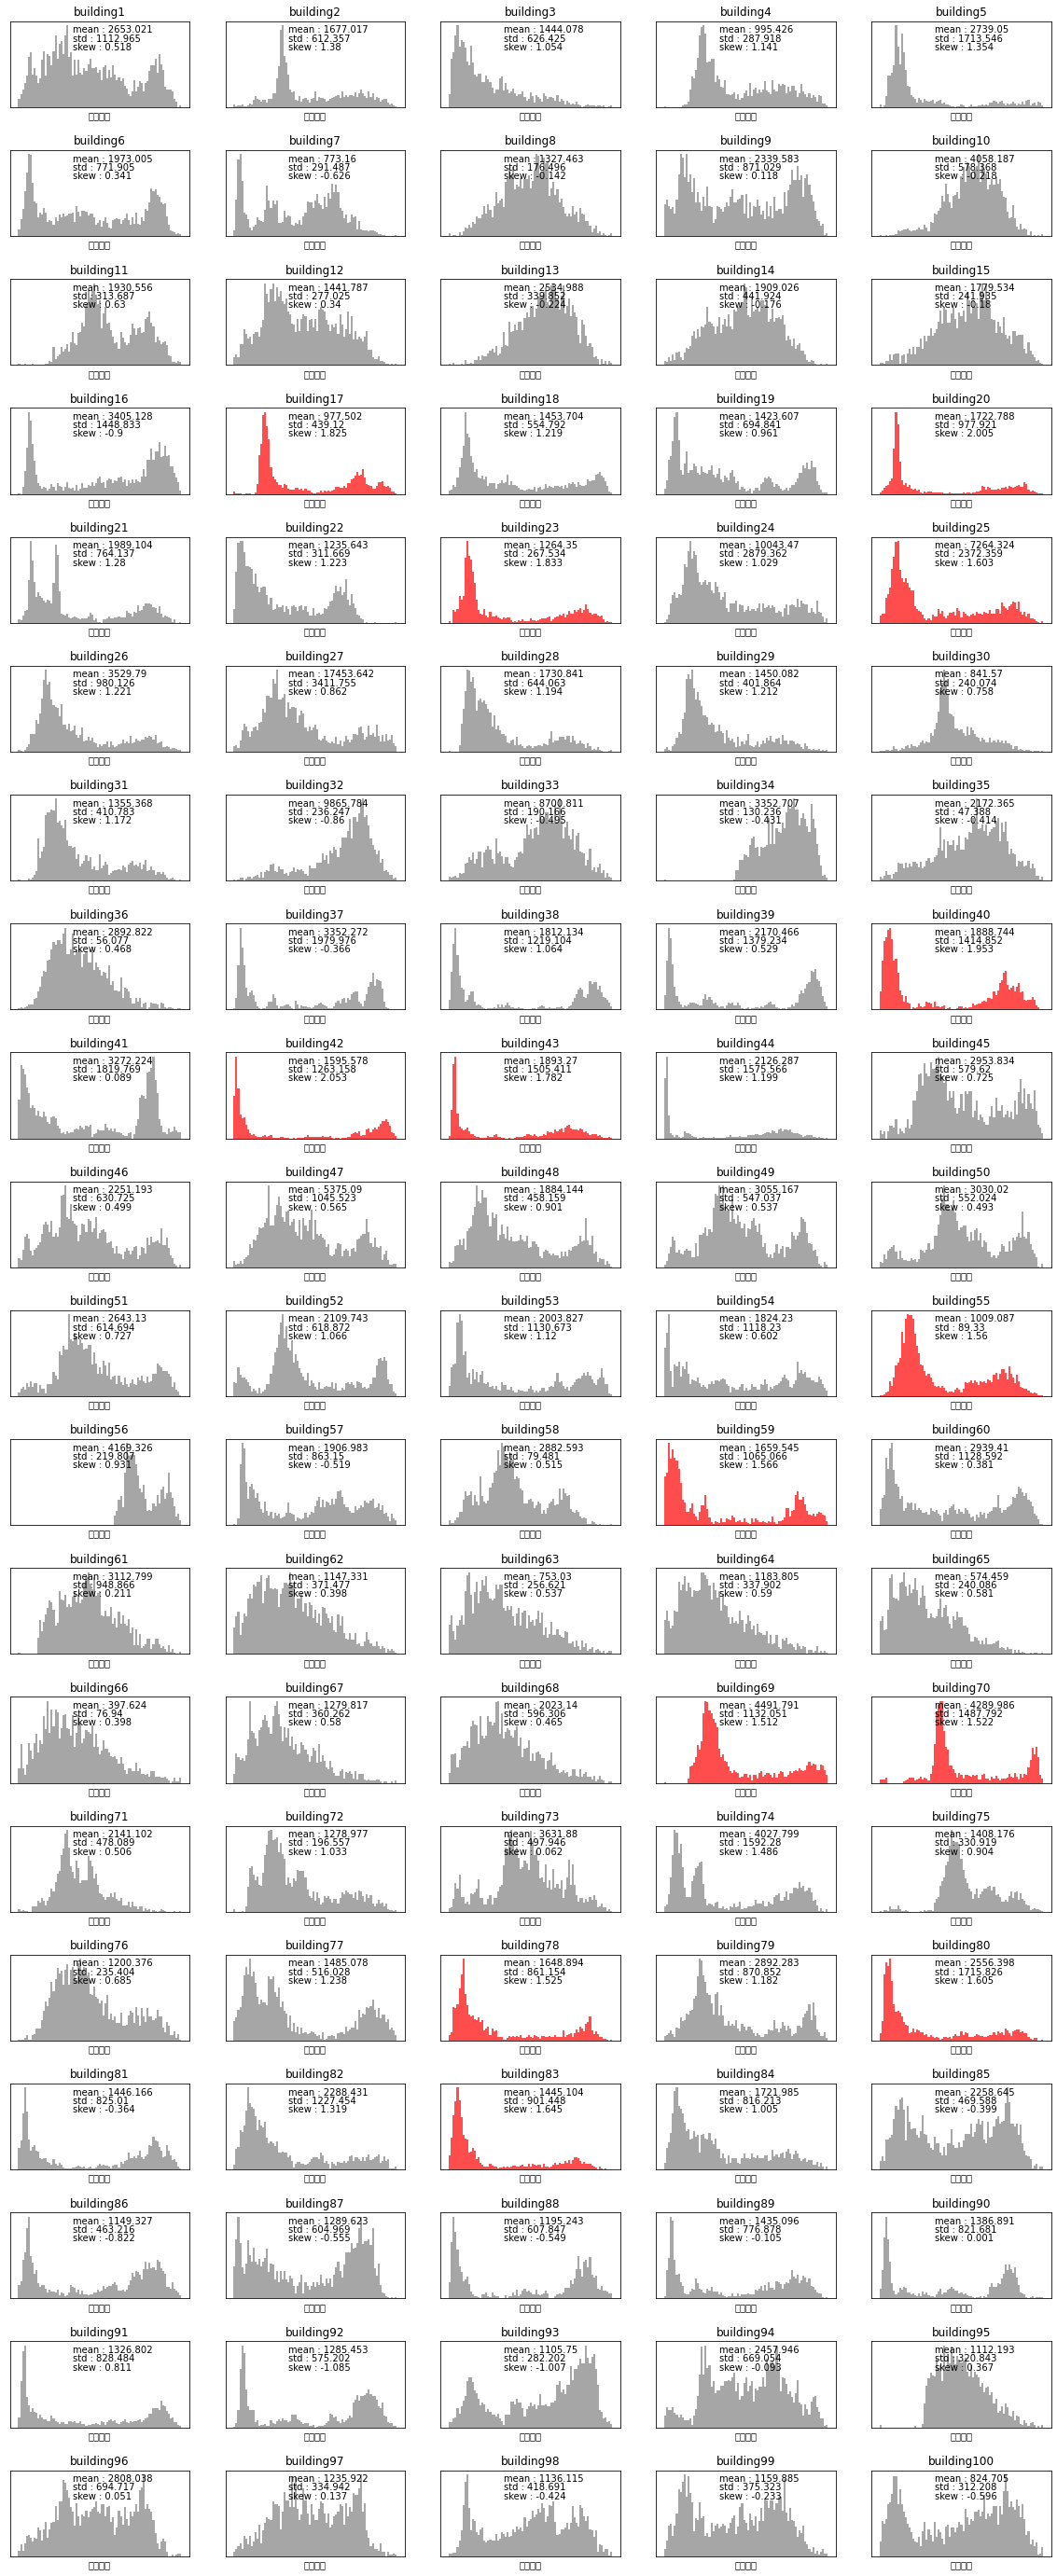

In [70]:
# 시각화
grid = gridspec.GridSpec(20, 5)
fig = plt.figure(figsize = (20, 50))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

building_num = list(set(train1['건물번호'].tolist())) # set으로 중복제거

for idx, num in enumerate(building_num): # enumerate를 통해 index와 value를 뽑아내어 각 plot에 순서대로 그릴 수 있도록 함
    ax = plt.subplot(grid[idx])
    energy = train1.loc[train1.건물번호 == num, '전력소비량(kWh)'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 85, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 85, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 85, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train1['건물유형'][idx])
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)



c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning

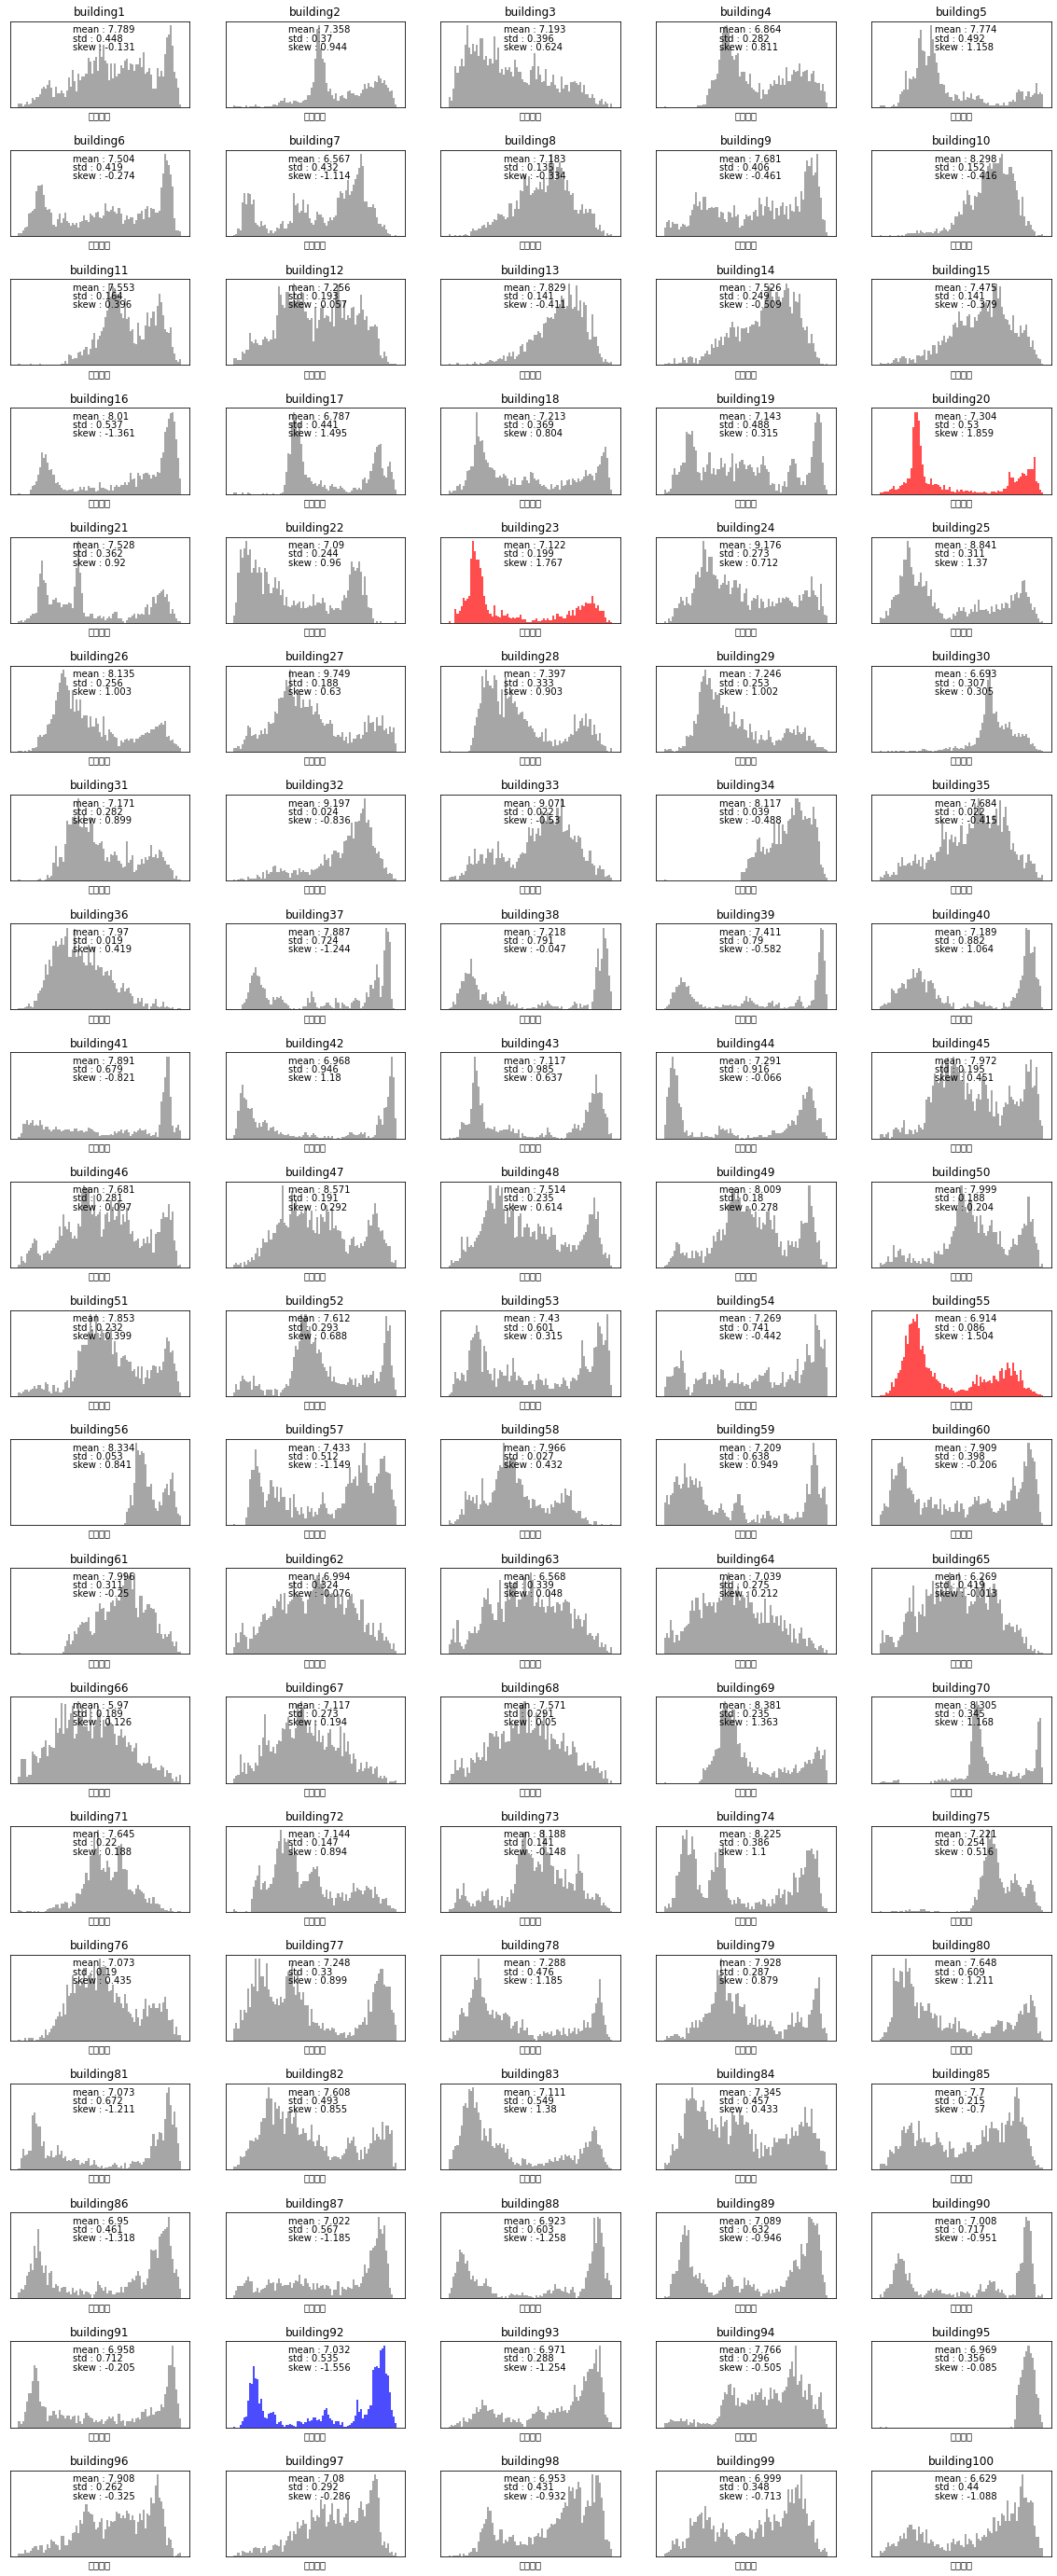

In [71]:
# 시각화
grid = gridspec.GridSpec(20, 5)
fig = plt.figure(figsize = (20, 50))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

building_num = list(set(train1['건물번호'].tolist())) # set으로 중복제거

for idx, num in enumerate(building_num): # enumerate를 통해 index와 value를 뽑아내어 각 plot에 순서대로 그릴 수 있도록 함
    ax = plt.subplot(grid[idx])
    energy = np.log1p(train1.loc[train1.건물번호 == num, '전력소비량(kWh)'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 85, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 85, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 85, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train1['건물유형'][idx])
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)



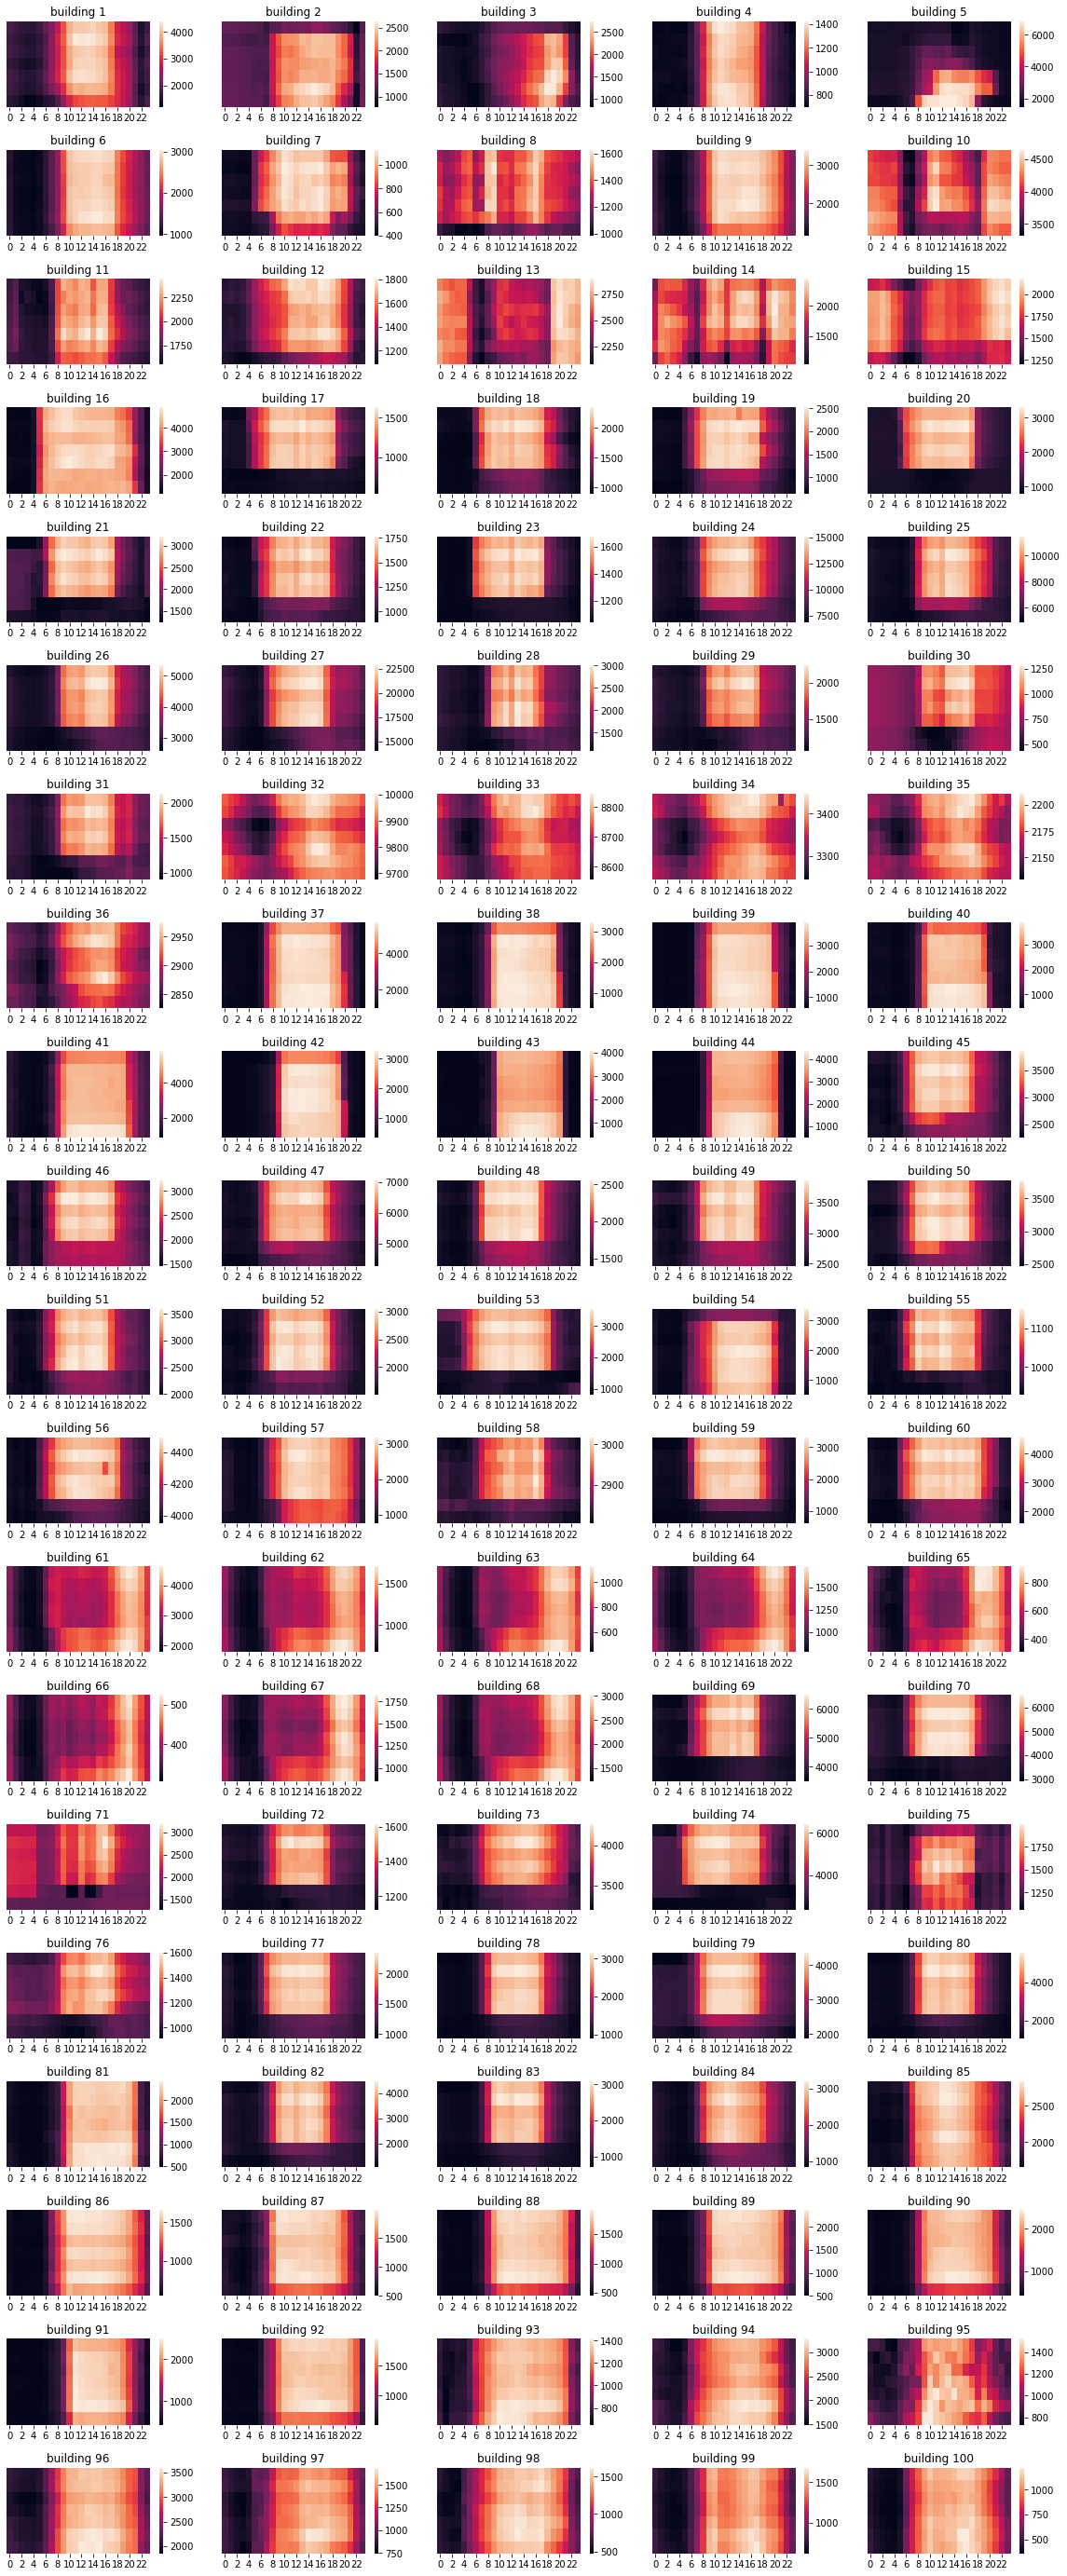

In [89]:
grid = gridspec.GridSpec(20, 5)
fig = plt.figure(figsize = (20, 50))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

for idx, num in enumerate(building_num):
    df = train1[train1['건물번호'] == num].groupby(['요일', '시간'])['전력소비량(kWh)'].mean().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(grid[idx])
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])


In [114]:
by_weekday = train1.groupby(['건물번호','요일'])['전력소비량(kWh)'].median().reset_index().pivot('건물번호','요일','전력소비량(kWh)').reset_index()
by_hour = train1.groupby(['건물번호','시간'])['전력소비량(kWh)'].median().reset_index().pivot('건물번호','시간','전력소비량(kWh)').reset_index().drop('건물번호', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['건물번호'] + ['일'+str(i) for i in range(7)] + ['시간'+str(i) for i in range(24)]
df.columns = columns

In [115]:
df

건물번호       일0       일1       일2        일3       일4       일5       일6  \
0      1  2388.48  2585.52  2455.92  2484.000  2599.68  2506.08  2116.80   
1      2  1219.32  1755.90  1546.38  1723.680  1517.22  1644.66  1465.02   
2      3  1119.60  1290.78  1236.42  1302.120  1318.32  1271.16  1255.68   
3      4   902.07   910.26   884.52   889.290   880.92   875.34   873.63   
4      5  1789.20  1822.32  1941.84  2030.760  2472.12  2739.96  2277.72   
..   ...      ...      ...      ...       ...      ...      ...      ...   
95    96  2761.92  2707.74  2728.68  2775.000  2797.68  2928.72  2868.66   
96    97  1160.19  1193.49  1160.46  1221.660  1244.07  1312.56  1268.55   
97    98  1170.99  1179.72  1173.15  1213.965  1249.02  1238.67  1153.62   
98    99  1189.62  1144.17  1143.09  1118.970  1196.82  1222.74  1234.53   
99   100   891.24   843.12   834.48   893.760   921.48   949.92   917.76   

        시간0      시간1  ...     시간14     시간15     시간16     시간17     시간18  \
0   1770.24  1714.56  ...  4336.32  4216.32  4140.96  3607.68  2894.40   
1   1239.84  1229.04  ...  2382.84  2415.24  2453.76  2292.84  2354.40   
2    959.76   908.64  ...  1692.36  1871.28  1963.08  2055.24  2524.68   
3    717.66   709.20  ...  1332.54  1323.18  1299.06  1187.82  1026.36   
4   1839.60  1825.20  ...  3434.40  3309.84  2921.76  2541.60  2094.48   
..      ...      ...  ...      ...      ...      ...      ...      ...   
95  2122.56  2097.24  ...  3588.36  3624.84  3536.16  3554.76  3444.24   
96   898.56   850.50  ...  1629.18  1603.08  1596.60  1587.78  1549.62   
97   530.46   501.30  ...  1587.78  1553.40  1593.54  1625.76  1490.94   
98   750.42   694.62  ...  1523.52  1572.30  1615.68  1627.38  1530.00   
99   451.44   404.40  ...  1127.76  1156.32  1169.04  1173.36  1119.36   

       시간19     시간20     시간21     시간22     시간23  
0   2733.60  2504.64  1986.72  1459.68  1867.68  
1   2039.40  1829.16  1514.88   831.24  1289.16  
2   2616.12  2462.04  1949.04  1150.56  1018.80  
3    870.48   820.80   782.10   764.28   721.08  
4   1846.08  1781.28  1724.40  1674.72  1658.88  
..      ...      ...      ...      ...      ...  
95  3323.04  3086.16  3001.92  2538.60  2323.80  
96  1520.10  1490.40  1345.86  1164.42  1002.96  
97  1383.12  1291.68  1130.04   855.72   663.66  
98  1416.06  1388.16  1239.48  1006.56   855.54  
99  1035.36   952.08   836.64   738.96   597.36  

[100 rows x 32 columns]

In [116]:
for i in range(len(df)):
    df.iloc[i, 1:8] = (df.iloc[i, 1:8] - df.iloc[i, 1:8].mean())/df.iloc[i, 1:8].std()
    df.iloc[i, 8:] = (df.iloc[i, 8:] - df.iloc[i, 8:].mean())/df.iloc[i, 8:].std()


In [117]:
df

건물번호        일0        일1        일2        일3        일4        일5  \
0      1 -0.365033  0.842013  0.048097  0.220112  0.928756  0.355372   
1      2 -1.832654  1.112889 -0.037266  0.936019 -0.197339  0.502240   
2      3 -2.059300  0.519474 -0.299443  0.690307  0.934355  0.223904   
3      4  1.027605  1.625945 -0.254553  0.093931 -0.517560 -0.925220   
4      5 -1.021251 -0.928384 -0.593254 -0.343926  0.893631  1.644644   
..   ...       ...       ...       ...       ...       ...       ...   
95    96 -0.428483 -1.120118 -0.852808 -0.261510  0.028011  1.700802   
96    97 -1.108302 -0.520686 -1.103538 -0.023595  0.371854  1.580437   
97    98 -0.705989 -0.469207 -0.647404  0.459617  1.410409  1.129687   
98    99  0.252212 -0.784497 -0.809131 -1.359305  0.416443  1.007675   
99   100 -0.044498 -1.190415 -1.396166  0.015513  0.675630  1.352893   

          일6       시간0       시간1  ...      시간14      시간15      시간16      시간17  \
0  -2.029317 -0.903789 -0.954297  ...  1.423925  1.315072  1.246712  0.762969   
1  -0.483890 -0.930175 -0.949983  ...  1.166164  1.225588  1.296236  1.001098   
2  -0.009297 -0.865560 -0.955021  ...  0.416518  0.729634  0.890288  1.051571   
3  -1.050148 -1.006087 -1.036407  ...  1.197574  1.164029  1.077586  0.678914   
4   0.348541 -0.777633 -0.799466  ...  1.640416  1.451557  0.863147  0.286745   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.934106 -1.238255 -1.278298  ...  1.079826  1.137517  0.997275  1.026690   
96  0.803831 -1.225923 -1.388949  ...  1.252432  1.163898  1.141917  1.111998   
97 -1.177114 -1.474814 -1.545078  ...  1.072895  0.990053  1.086774  1.164411   
98  1.276603 -1.159134 -1.310561  ...  0.938871  1.071249  1.188971  1.220722   
99  0.587043 -1.260301 -1.413187  ...  0.937824  1.030648  1.071989  1.086030   

        시간18      시간19      시간20      시간21      시간22      시간23  
0   0.115947 -0.029916 -0.237608 -0.707418 -1.185501 -0.815400  
1   1.114004  0.536272  0.150678 -0.425733 -1.679575 -0.839719  
2   1.873108  2.033132  1.763486  0.865717 -0.531652 -0.762237  
3   0.100259 -0.458397 -0.636445 -0.775141 -0.839006 -0.993830  
4  -0.391182 -0.767808 -0.866058 -0.952300 -1.027625 -1.051642  
..       ...       ...       ...       ...       ...       ...  
95  0.851908  0.660237  0.285625  0.152404 -0.580311 -0.920005  
96  0.982555  0.882419  0.781673  0.291375 -0.324092 -0.871785  
97  0.839550  0.579748  0.359415 -0.030072 -0.691071 -1.153857  
98  0.956457  0.647251  0.571537  0.168056 -0.464032 -0.873863  
99  0.910523  0.637512  0.366842 -0.008353 -0.325825 -0.786043  

[100 rows x 32 columns]

c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0, flags=flags)


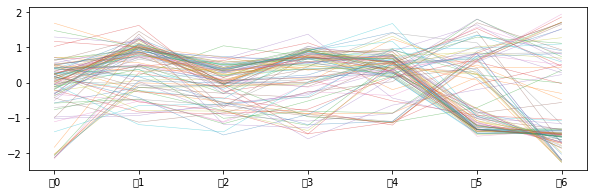

c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0, flags=flags)


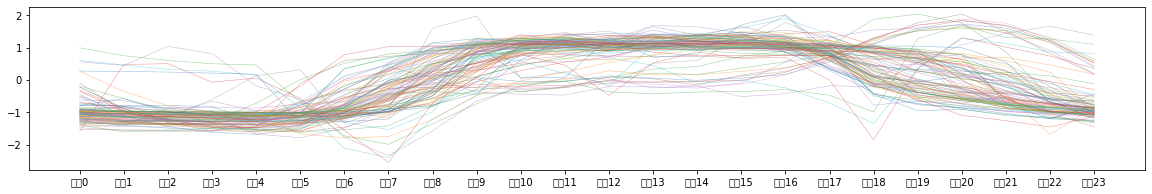

In [118]:
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

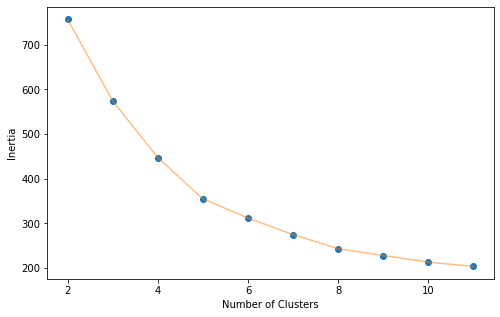

In [121]:
# elbow 탐색
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

# k = 5로 결정

In [128]:
kmeans = KMeans(n_clusters = 5, random_state= 42)
km_cluster = kmeans.fit_predict(df.iloc[:, 1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

In [130]:
km_cluster

array([0, 1, 1, 0, 1, 2, 0, 0, 2, 4, 0, 2, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1])

In [129]:
df_clust

건물번호        일0        일1        일2        일3        일4        일5  \
0      1 -0.365033  0.842013  0.048097  0.220112  0.928756  0.355372   
1      2 -1.832654  1.112889 -0.037266  0.936019 -0.197339  0.502240   
2      3 -2.059300  0.519474 -0.299443  0.690307  0.934355  0.223904   
3      4  1.027605  1.625945 -0.254553  0.093931 -0.517560 -0.925220   
4      5 -1.021251 -0.928384 -0.593254 -0.343926  0.893631  1.644644   
..   ...       ...       ...       ...       ...       ...       ...   
95    96 -0.428483 -1.120118 -0.852808 -0.261510  0.028011  1.700802   
96    97 -1.108302 -0.520686 -1.103538 -0.023595  0.371854  1.580437   
97    98 -0.705989 -0.469207 -0.647404  0.459617  1.410409  1.129687   
98    99  0.252212 -0.784497 -0.809131 -1.359305  0.416443  1.007675   
99   100 -0.044498 -1.190415 -1.396166  0.015513  0.675630  1.352893   

          일6       시간0       시간1  ...      시간15      시간16      시간17      시간18  \
0  -2.029317 -0.903789 -0.954297  ...  1.315072  1.246712  0.762969  0.115947   
1  -0.483890 -0.930175 -0.949983  ...  1.225588  1.296236  1.001098  1.114004   
2  -0.009297 -0.865560 -0.955021  ...  0.729634  0.890288  1.051571  1.873108   
3  -1.050148 -1.006087 -1.036407  ...  1.164029  1.077586  0.678914  0.100259   
4   0.348541 -0.777633 -0.799466  ...  1.451557  0.863147  0.286745 -0.391182   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.934106 -1.238255 -1.278298  ...  1.137517  0.997275  1.026690  0.851908   
96  0.803831 -1.225923 -1.388949  ...  1.163898  1.141917  1.111998  0.982555   
97 -1.177114 -1.474814 -1.545078  ...  0.990053  1.086774  1.164411  0.839550   
98  1.276603 -1.159134 -1.310561  ...  1.071249  1.188971  1.220722  0.956457   
99  0.587043 -1.260301 -1.413187  ...  1.030648  1.071989  1.086030  0.910523   

        시간19      시간20      시간21      시간22      시간23  km_cluster  
0  -0.029916 -0.237608 -0.707418 -1.185501 -0.815400           0  
1   0.536272  0.150678 -0.425733 -1.679575 -0.839719           1  
2   2.033132  1.763486  0.865717 -0.531652 -0.762237           1  
3  -0.458397 -0.636445 -0.775141 -0.839006 -0.993830           0  
4  -0.767808 -0.866058 -0.952300 -1.027625 -1.051642           1  
..       ...       ...       ...       ...       ...         ...  
95  0.660237  0.285625  0.152404 -0.580311 -0.920005           1  
96  0.882419  0.781673  0.291375 -0.324092 -0.871785           1  
97  0.579748  0.359415 -0.030072 -0.691071 -1.153857           1  
98  0.647251  0.571537  0.168056 -0.464032 -0.873863           1  
99  0.637512  0.366842 -0.008353 -0.325825 -0.786043           1  

[100 rows x 33 columns]

In [142]:
temp = df_clust[df_clust.km_cluster == k]

temp

건물번호        일0        일1        일2        일3        일4        일5  \
9     10  0.154542 -0.219677 -0.460553  0.892226  1.679376 -0.965964   
12    13  0.403577  0.211234  1.046723  0.740177  0.265330 -0.822610   
13    14  0.073833  0.470497  0.626829  1.131992  0.295498 -0.735828   
14    15 -0.302713  0.733700  0.705721  0.684737  0.751287 -0.771957   

          일6       시간0       시간1  ...      시간15      시간16      시간17      시간18  \
9  -1.079950  0.604817  0.464124  ... -0.004851 -0.242574 -0.709932 -1.342240   
12 -1.844432  0.994276  0.749186  ... -0.356121 -0.293647 -0.471458 -0.988069   
13 -1.862820 -1.593223  0.478133  ...  0.669519  0.697430 -0.004319 -1.844417   
14 -1.800776  0.561142  0.448997  ... -0.513247 -0.421629 -0.175811 -0.205349   

        시간19      시간20      시간21      시간22      시간23  km_cluster  
9   0.347689  1.279171  1.128776  0.865179  0.826367           4  
12  1.280214  1.681489  1.311451  1.265797  1.097598           4  
13  0.358517  1.309466  1.012419  0.739295  0.358517           4  
14  0.547625  1.082316  1.442282  1.660064  1.380202           4  

[4 rows x 33 columns]

<Figure size 432x288 with 0 Axes>

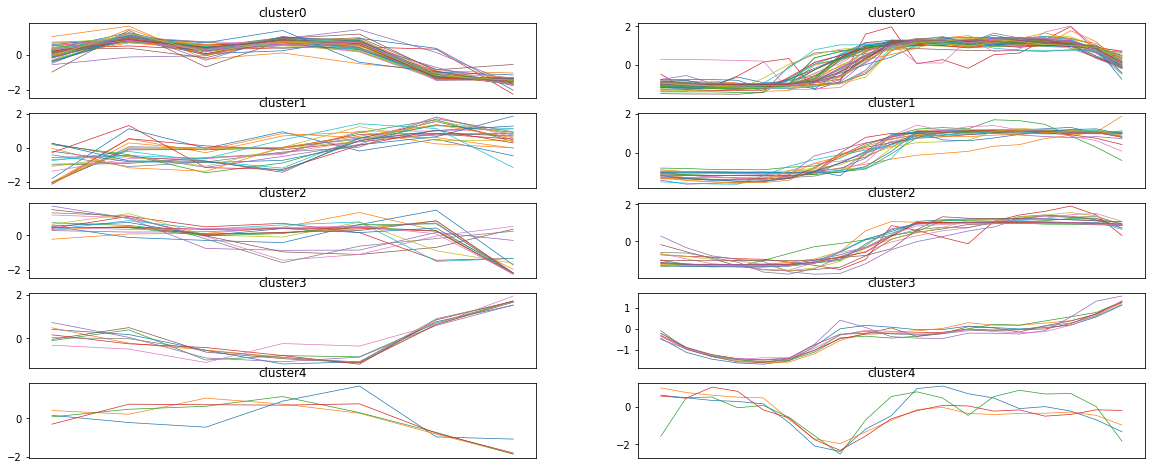

In [149]:
n_c = len(np.unique(df_clust.km_cluster)) 

grid = gridspec.GridSpec(5, 2)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

fig = plt.figure(figsize = (20, 8))
for k in range(n_c):
    temp = df_clust[df_clust.km_cluster == k]
    plt.subplot(grid[2*k])
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7)
        plt.title(f'cluster{k}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(grid[2*k+1])
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{k}')
        plt.xlabel('')
        plt.xticks([])

In [153]:
eda_df = train1.merge(df_clust[['건물번호','km_cluster']], on = '건물번호', how = 'left')

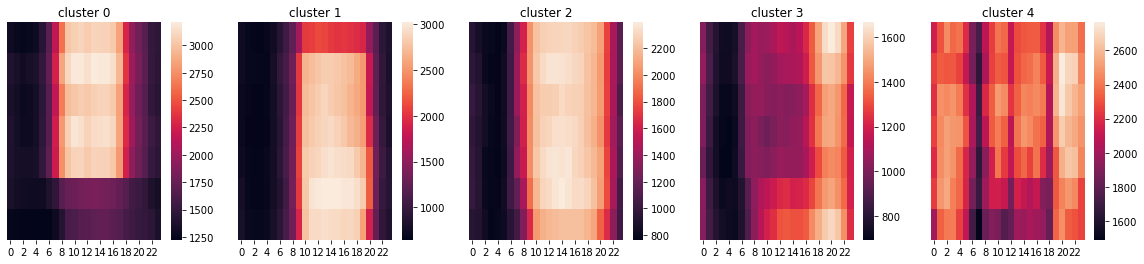

In [155]:
fig = plt.figure(figsize = (20, 4))
grid = gridspec.GridSpec(1,5)

for k in range(5):
    temp = eda_df[eda_df.km_cluster == k]
    temp = temp.groupby(['요일', '시간'])['전력소비량(kWh)'].median().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(grid[k])
    sns.heatmap(temp)
    plt.title(f'cluster {k}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [160]:
match = df_clust[['건물번호', 'km_cluster']]
cluster2num = {0:[], 1:[], 2:[], 3:[], 4:[]}
for i in range(100):
    k = match.iloc[i, 1]
    cluster2num[k].append(i+1)

print(cluster2num)

{0: [1, 4, 7, 8, 11, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84], 1: [2, 3, 5, 37, 38, 39, 40, 41, 42, 43, 44, 54, 81, 85, 93, 94, 95, 96, 97, 98, 99, 100], 2: [6, 9, 12, 30, 32, 33, 34, 35, 36, 57, 86, 87, 88, 89, 90, 91, 92], 3: [61, 62, 63, 64, 65, 66, 67, 68], 4: [10, 13, 14, 15]}


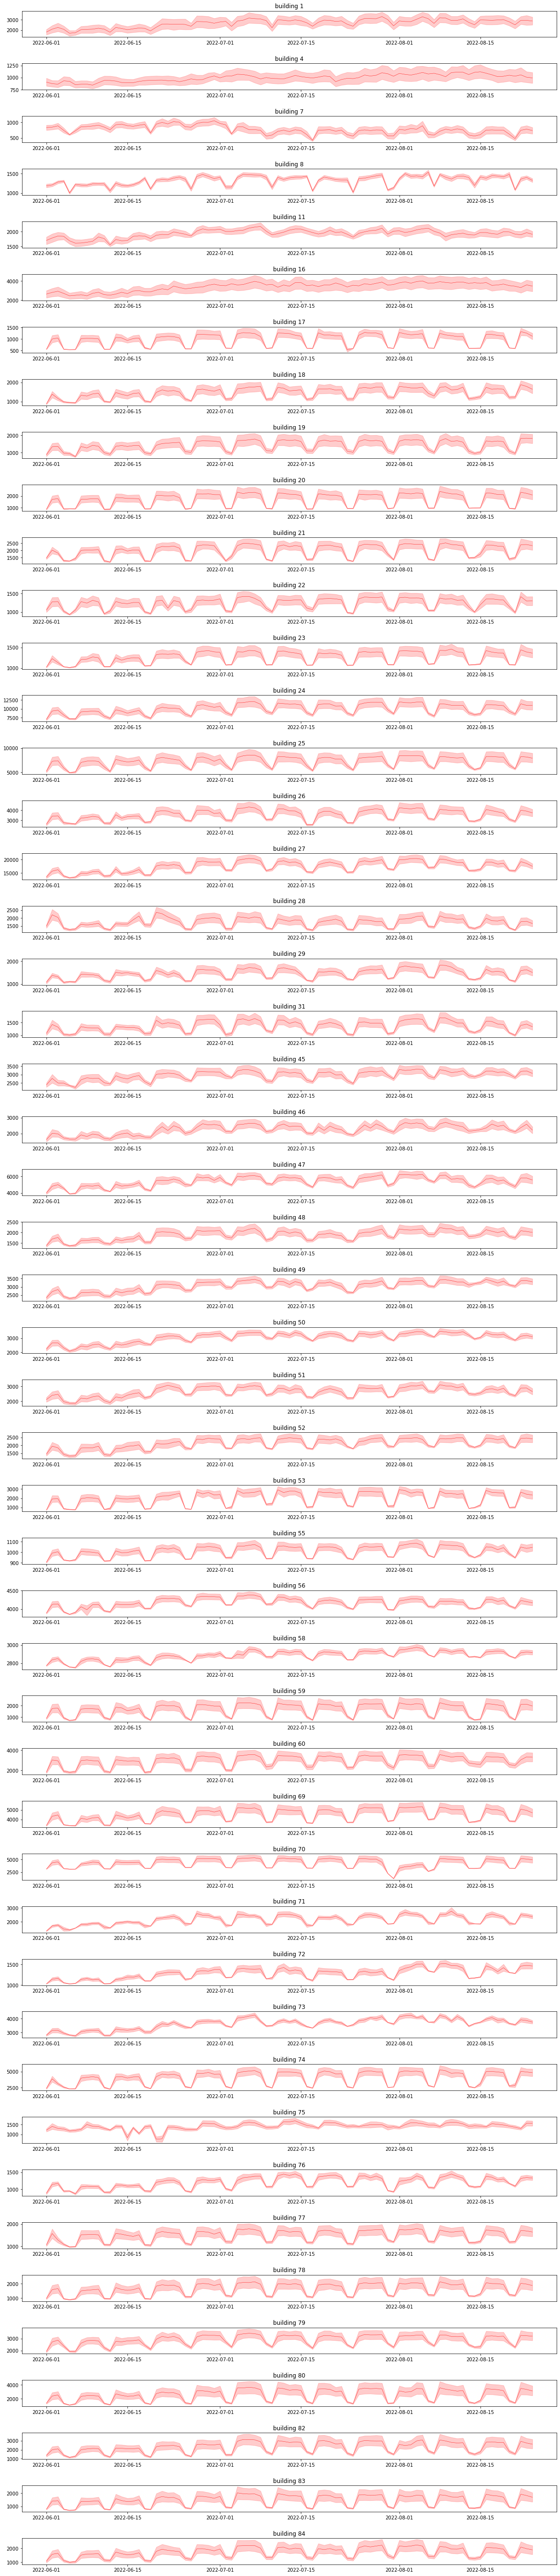

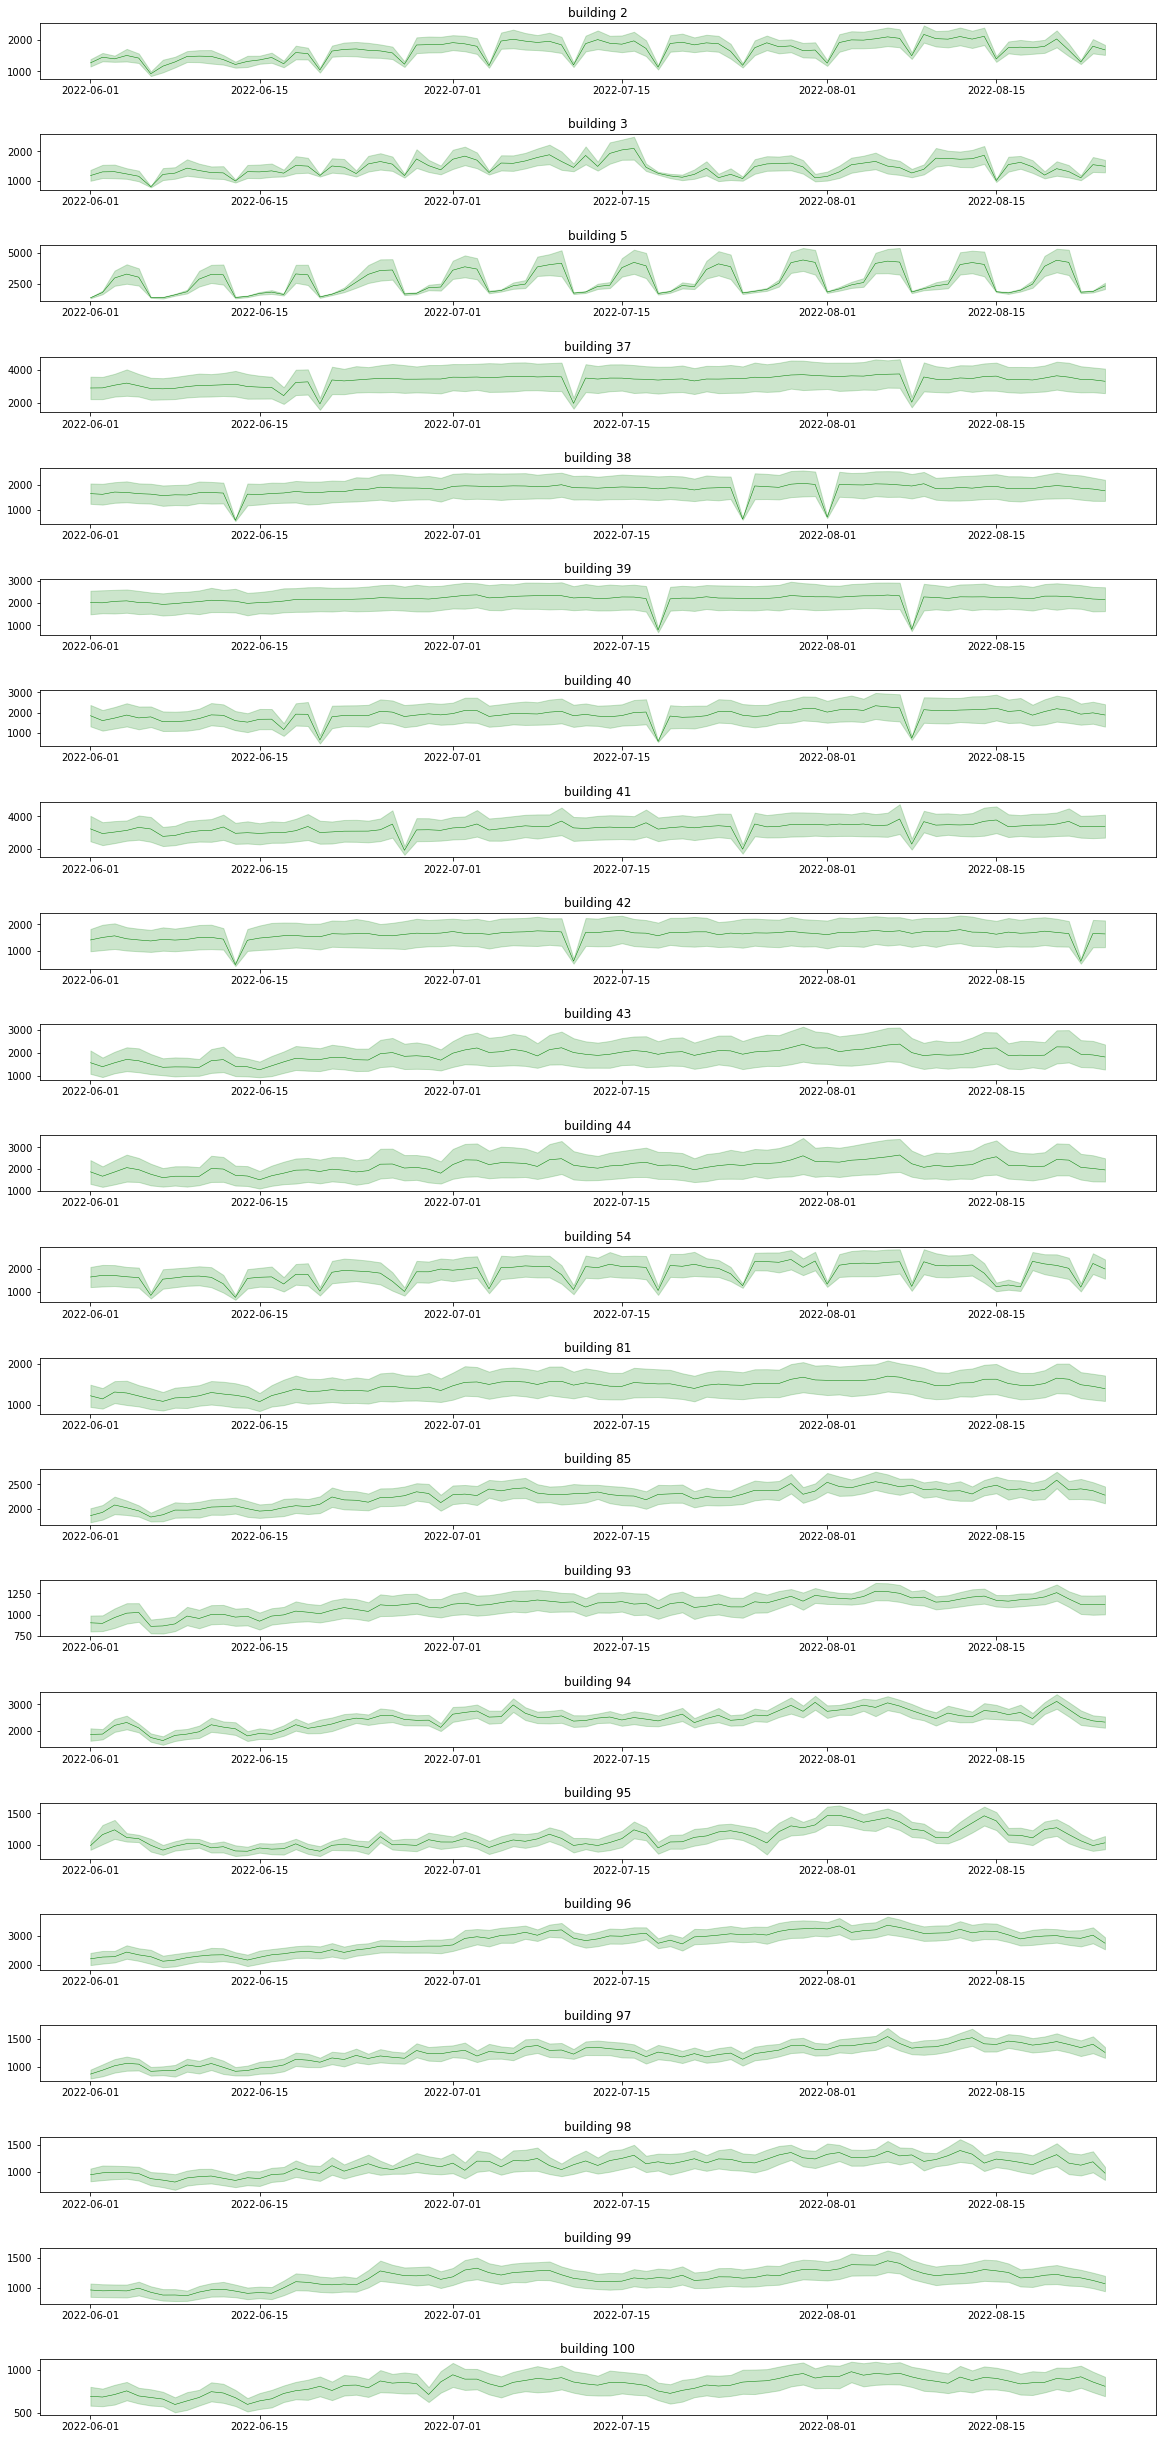

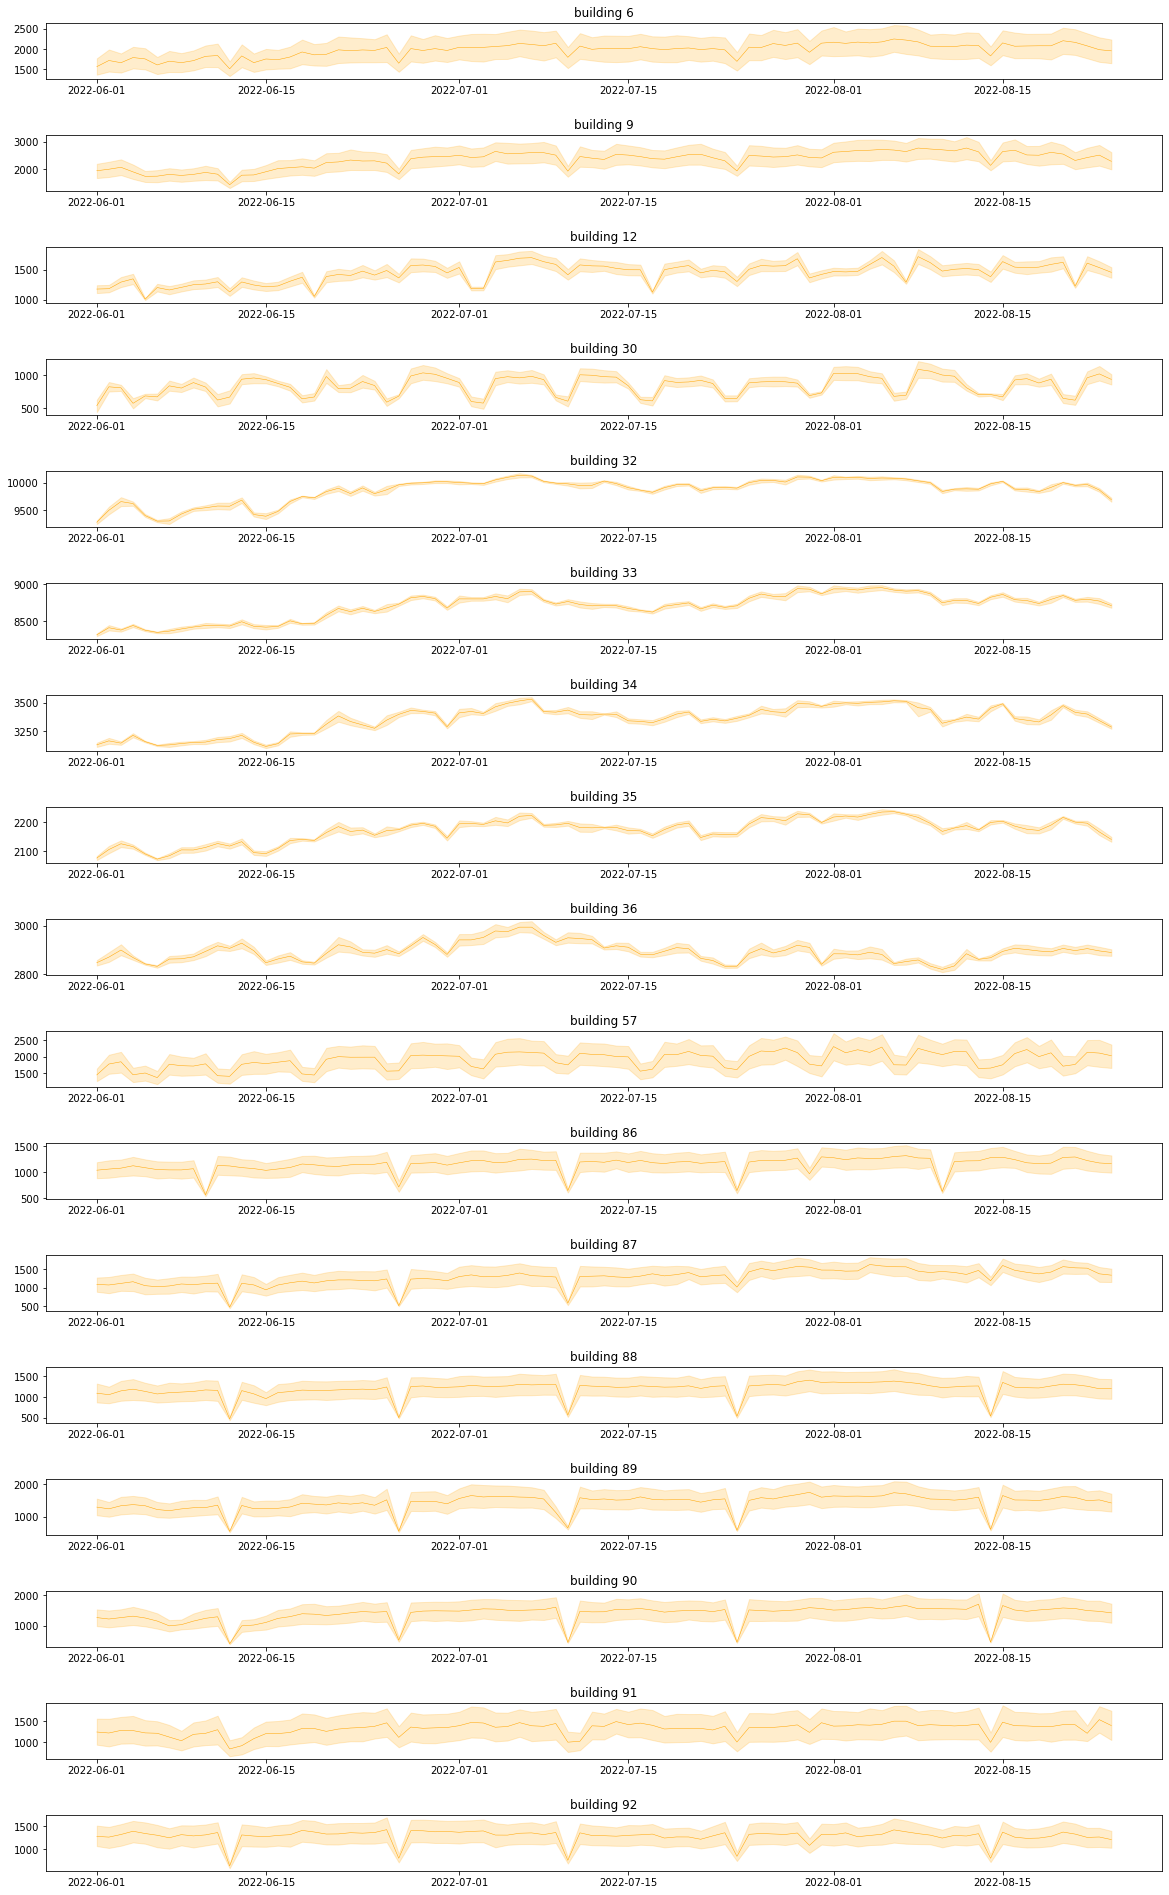

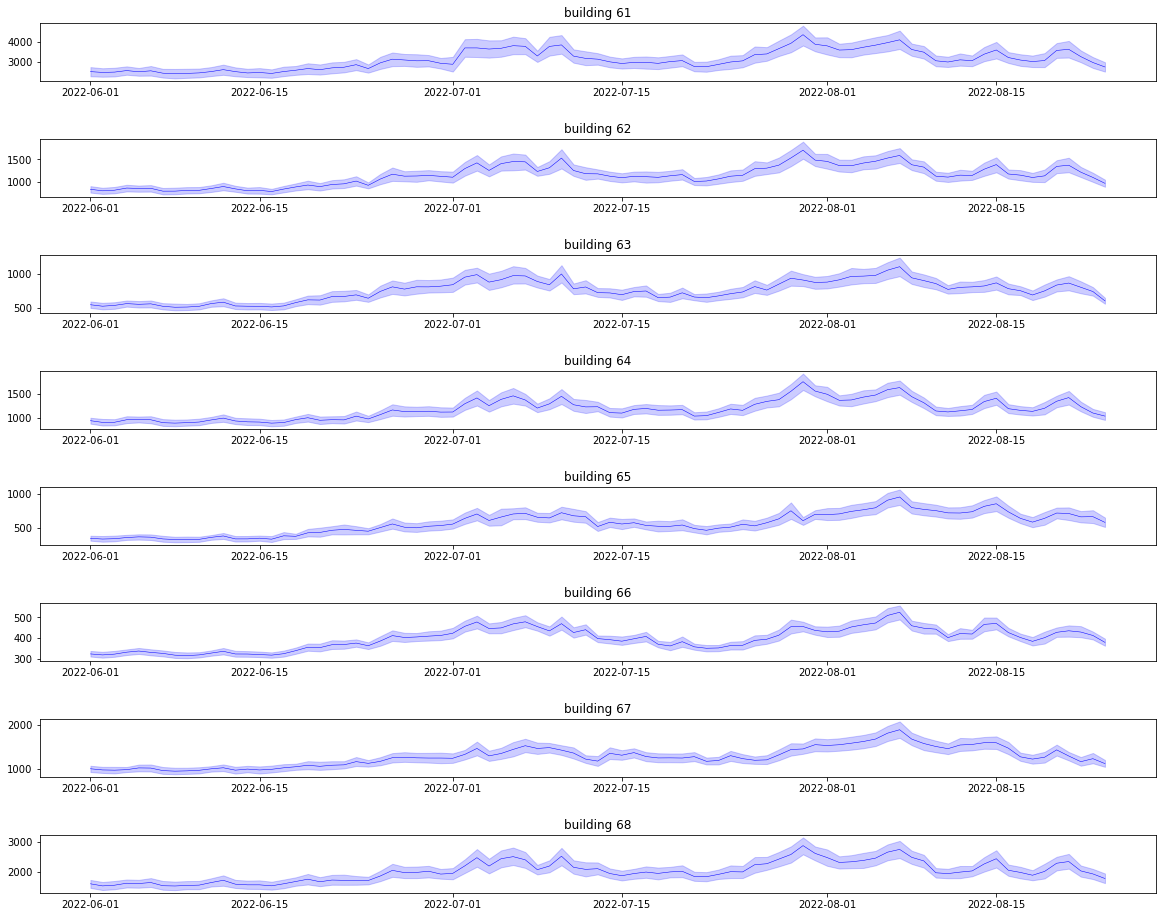

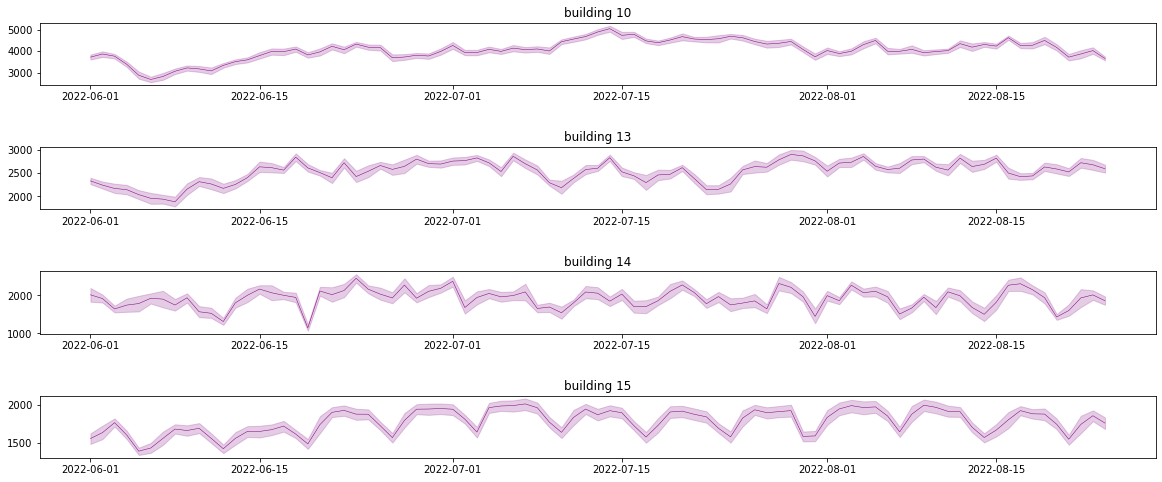

In [166]:
# 시각화
for c, col in enumerate(['red','green','orange','blue', 'purple']):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.건물번호)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 2*n_nums))
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.건물번호 == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= '날짜', y = '전력소비량(kWh)', linewidth = 0.5, color = col)
        plt.title(f'building {num}')
        plt.subplots_adjust(hspace = 1)
        plt.ylabel('')
        plt.xlabel('')

In [167]:
train

num_date_time  건물번호           일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  \
0         1_20220601 00     1  20220601 00   18.6      NaN      0.9   42.0   
1         1_20220601 01     1  20220601 01   18.0      NaN      1.1   45.0   
2         1_20220601 02     1  20220601 02   17.7      NaN      1.5   45.0   
3         1_20220601 03     1  20220601 03   16.7      NaN      1.4   48.0   
4         1_20220601 04     1  20220601 04   18.4      NaN      2.8   43.0   
...                 ...   ...          ...    ...      ...      ...    ...   
203995  100_20220824 19   100  20220824 19   23.1      NaN      0.9   86.0   
203996  100_20220824 20   100  20220824 20   22.4      NaN      1.3   86.0   
203997  100_20220824 21   100  20220824 21   21.3      NaN      1.0   92.0   
203998  100_20220824 22   100  20220824 22   21.0      NaN      0.3   94.0   
203999  100_20220824 23   100  20220824 23   20.7      NaN      0.1   95.0   

        일조(hr)  일사(MJ/m2)  전력소비량(kWh)  
0          NaN        NaN     1085.28  
1          NaN        NaN     1047.36  
2          NaN        NaN      974.88  
3          NaN        NaN      953.76  
4          NaN        NaN      986.40  
...        ...        ...         ...  
203995     0.5        NaN      881.04  
203996     0.0        NaN      798.96  
203997     NaN        NaN      825.12  
203998     NaN        NaN      640.08  
203999     NaN        NaN      540.24  

[204000 rows x 10 columns]

In [193]:
# cluster 0
df_0 = eda_df[eda_df.km_cluster == 0]
df = df_0.groupby(['건물번호','날짜'])[['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)', '전력소비량(kWh)']].mean().reset_index()
corrs_0 = []
for num in cluster2num[0]:
    corr = []
    corr.append(num)
    for feat in ['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']:
        corr.append(spearmanr(df.loc[df.건물번호 == num, feat], df.loc[df.건물번호 == num, '전력소비량(kWh)']).correlation)
    corrs_0.append(corr)

# cluster 1
df_1 = eda_df[eda_df.km_cluster == 1]
df = df_1.groupby(['건물번호','날짜'])[['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)', '전력소비량(kWh)']].mean().reset_index()
corrs_1 = []
for num in cluster2num[1]:
    corr = []
    corr.append(num)
    for feat in ['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']:
        corr.append(spearmanr(df.loc[df.건물번호 == num, feat], df.loc[df.건물번호 == num, '전력소비량(kWh)']).correlation)
    corrs_1.append(corr)
    
# cluster 2
df_2 = eda_df[eda_df.km_cluster == 2]
df = df_2.groupby(['건물번호','날짜'])[['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)', '전력소비량(kWh)']].mean().reset_index()
corrs_2 = []
for num in cluster2num[2]:
    corr = []
    corr.append(num)
    for feat in ['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']:
        corr.append(spearmanr(df.loc[df.건물번호 == num, feat], df.loc[df.건물번호 == num, '전력소비량(kWh)']).correlation)
    corrs_2.append(corr)
    
# cluster 3
df_3 = eda_df[eda_df.km_cluster == 3]
df = df_3.groupby(['건물번호','날짜'])[['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)', '전력소비량(kWh)']].mean().reset_index()
corrs_3 = []
for num in cluster2num[3]:
    corr = []
    corr.append(num)
    for feat in ['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']:
        corr.append(spearmanr(df.loc[df.건물번호 == num, feat], df.loc[df.건물번호 == num, '전력소비량(kWh)']).correlation)
    corrs_3.append(corr)

# cluster4
df_4 = eda_df[eda_df.km_cluster == 4]
df = df_4.groupby(['건물번호','날짜'])[['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)', '전력소비량(kWh)']].mean().reset_index()
corrs_4 = []
for num in cluster2num[4]:
    corr = []
    corr.append(num)
    for feat in ['기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']:
        corr.append(spearmanr(df.loc[df.건물번호 == num, feat], df.loc[df.건물번호 == num, '전력소비량(kWh)']).correlation)
    corrs_4.append(corr)
       
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3, corrs_4]

In [189]:
corrs_total

[[[1,
   0.6686698131041628,
   nan,
   0.024840350472991397,
   0.23564532538326008,
   -0.053717471261622,
   -0.05895113300196424],
  [4,
   0.7501148145249108,
   nan,
   -0.1300747069811127,
   0.2615892747464181,
   -0.013137478359691661,
   -0.0281906213675894],
  [7,
   -0.2818657507643117,
   nan,
   0.16013016026543245,
   -0.33335124828337487,
   0.11341119549500074,
   0.10097713504006255],
  [8,
   0.46479836621424875,
   nan,
   0.21988019542743906,
   0.26977403203093325,
   -0.07329800813265394,
   nan],
  [11,
   0.6762231407381349,
   nan,
   0.08079505158855455,
   0.29867839260567614,
   -0.059899868751912284,
   nan],
  [16,
   0.8775692670090421,
   nan,
   0.16066446810705837,
   0.2648771717756504,
   -0.06587285998322459,
   -0.08041860669729894],
  [17,
   0.40197774066547404,
   nan,
   0.10220504547482968,
   0.11877540659479685,
   -0.03388861109363331,
   -0.05633238550577223],
  [18,
   0.440123315049786,
   nan,
   0.06735688013117873,
   0.2918704471764

c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

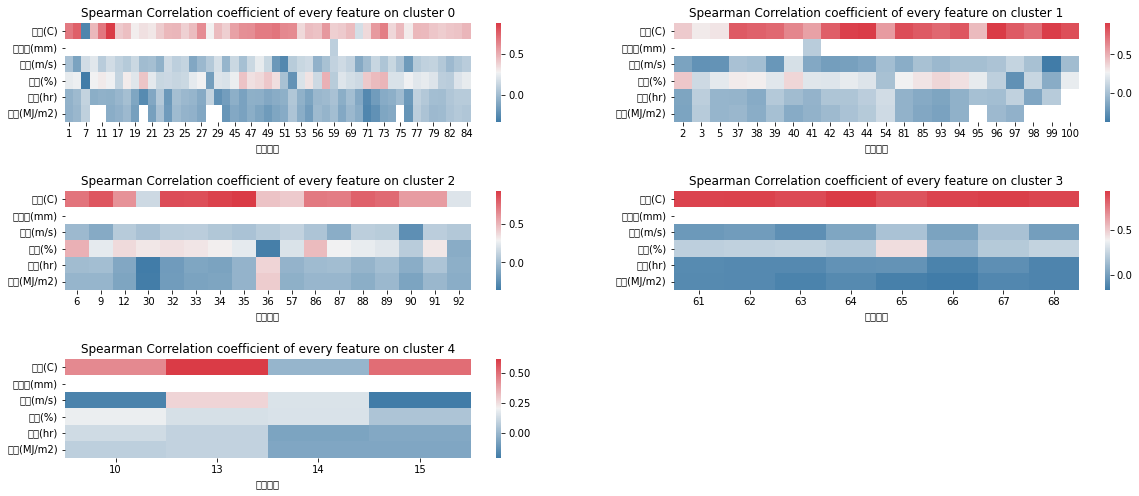

In [194]:
fig = plt.figure(figsize = (20, 8))
grid = gridspec.GridSpec(3,2)
for i, corrs in enumerate(corrs_total):    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['건물번호', '기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)'])
    corr_df['건물번호'] = corr_df['건물번호'].astype(int)
    corr_df = corr_df.set_index('건물번호')

    plt.subplot(grid[i])
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on cluster {i}')

In [198]:
eda_df

건물번호                  일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0          1 2022-06-01 00:00:00   18.6      NaN      0.9   42.0     NaN   
1          1 2022-06-01 01:00:00   18.0      NaN      1.1   45.0     NaN   
2          1 2022-06-01 02:00:00   17.7      NaN      1.5   45.0     NaN   
3          1 2022-06-01 03:00:00   16.7      NaN      1.4   48.0     NaN   
4          1 2022-06-01 04:00:00   18.4      NaN      2.8   43.0     NaN   
...      ...                 ...    ...      ...      ...    ...     ...   
203995   100 2022-08-24 19:00:00   23.1      NaN      0.9   86.0     0.5   
203996   100 2022-08-24 20:00:00   22.4      NaN      1.3   86.0     0.0   
203997   100 2022-08-24 21:00:00   21.3      NaN      1.0   92.0     NaN   
203998   100 2022-08-24 22:00:00   21.0      NaN      0.3   94.0     NaN   
203999   100 2022-08-24 23:00:00   20.7      NaN      0.1   95.0     NaN   

        일사(MJ/m2)  전력소비량(kWh)  시간  ...   일  월    연도    건물유형    연면적(m2)  \
0             NaN     1085.28   0  ...   1  6  2022    건물기타  110634.00   
1             NaN     1047.36   1  ...   1  6  2022    건물기타  110634.00   
2             NaN      974.88   2  ...   1  6  2022    건물기타  110634.00   
3             NaN      953.76   3  ...   1  6  2022    건물기타  110634.00   
4             NaN      986.40   4  ...   1  6  2022    건물기타  110634.00   
...           ...         ...  ..  ...  .. ..   ...     ...        ...   
203995        NaN      881.04  19  ...  24  8  2022  호텔및리조트   57497.84   
203996        NaN      798.96  20  ...  24  8  2022  호텔및리조트   57497.84   
203997        NaN      825.12  21  ...  24  8  2022  호텔및리조트   57497.84   
203998        NaN      640.08  22  ...  24  8  2022  호텔및리조트   57497.84   
203999        NaN      540.24  23  ...  24  8  2022  호텔및리조트   57497.84   

        냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh) PCS용량(kW) km_cluster  
0       39570.00          -             -         -          0  
1       39570.00          -             -         -          0  
2       39570.00          -             -         -          0  
3       39570.00          -             -         -          0  
4       39570.00          -             -         -          0  
...          ...        ...           ...       ...        ...  
203995  40035.23          -             -         -          1  
203996  40035.23          -             -         -          1  
203997  40035.23          -             -         -          1  
203998  40035.23          -             -         -          1  
203999  40035.23          -             -         -          1  

[204000 rows x 22 columns]

In [200]:
solar_df = eda_df.loc[eda_df['일조(hr)'] == 1.0]
solar_df

건물번호                  일시  기온(C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
7          1 2022-06-01 07:00:00   17.4      NaN      1.3   50.0     1.0   
8          1 2022-06-01 08:00:00   20.6      NaN      1.8   44.0     1.0   
9          1 2022-06-01 09:00:00   23.2      NaN      1.7   41.0     1.0   
10         1 2022-06-01 10:00:00   24.8      NaN      2.5   35.0     1.0   
11         1 2022-06-01 11:00:00   26.3      NaN      2.7   31.0     1.0   
...      ...                 ...    ...      ...      ...    ...     ...   
203841   100 2022-08-18 09:00:00   24.0      NaN      1.1   84.0     1.0   
203898   100 2022-08-20 18:00:00   28.3      NaN      2.3   77.0     1.0   
203899   100 2022-08-20 19:00:00   26.8      NaN      1.6   83.0     1.0   
203916   100 2022-08-21 12:00:00   30.3      NaN      1.3   70.0     1.0   
203920   100 2022-08-21 16:00:00   31.7      NaN      0.9   58.0     1.0   

        일사(MJ/m2)  전력소비량(kWh)  시간  ...   일  월    연도    건물유형    연면적(m2)  \
7            0.55     1684.80   7  ...   1  6  2022    건물기타  110634.00   
8            1.29     1976.16   8  ...   1  6  2022    건물기타  110634.00   
9            2.01     2289.12   9  ...   1  6  2022    건물기타  110634.00   
10           2.58     2683.20  10  ...   1  6  2022    건물기타  110634.00   
11           3.19     2730.72  11  ...   1  6  2022    건물기타  110634.00   
...           ...         ...  ..  ...  .. ..   ...     ...        ...   
203841        NaN     1055.28   9  ...  18  8  2022  호텔및리조트   57497.84   
203898        NaN     1228.32  18  ...  20  8  2022  호텔및리조트   57497.84   
203899        NaN     1147.44  19  ...  20  8  2022  호텔및리조트   57497.84   
203916        NaN     1094.16  12  ...  21  8  2022  호텔및리조트   57497.84   
203920        NaN     1317.84  16  ...  21  8  2022  호텔및리조트   57497.84   

        냉방면적(m2)  태양광용량(kW)  ESS저장용량(kWh) PCS용량(kW) km_cluster  
7       39570.00          -             -         -          0  
8       39570.00          -             -         -          0  
9       39570.00          -             -         -          0  
10      39570.00          -             -         -          0  
11      39570.00          -             -         -          0  
...          ...        ...           ...       ...        ...  
203841  40035.23          -             -         -          1  
203898  40035.23          -             -         -          1  
203899  40035.23          -             -         -          1  
203916  40035.23          -             -         -          1  
203920  40035.23          -             -         -          1  

[20879 rows x 22 columns]

C:\Users\LIMJAE~1\AppData\Local\Temp/ipykernel_17164/3684393592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_df['주말'] = solar_df['요일'].isin([5, 6]).astype(int)
C:\Users\LIMJAE~1\AppData\Local\Temp/ipykernel_17164/3684393592.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = solar_df.groupby(['건물번호','주말','날짜'])['일조(hr)','전력소비량(kWh)'].mean().reset_index()
c:\Users\LimJaeSung\anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\seaborn\regressio

<Figure size 1080x1800 with 0 Axes>

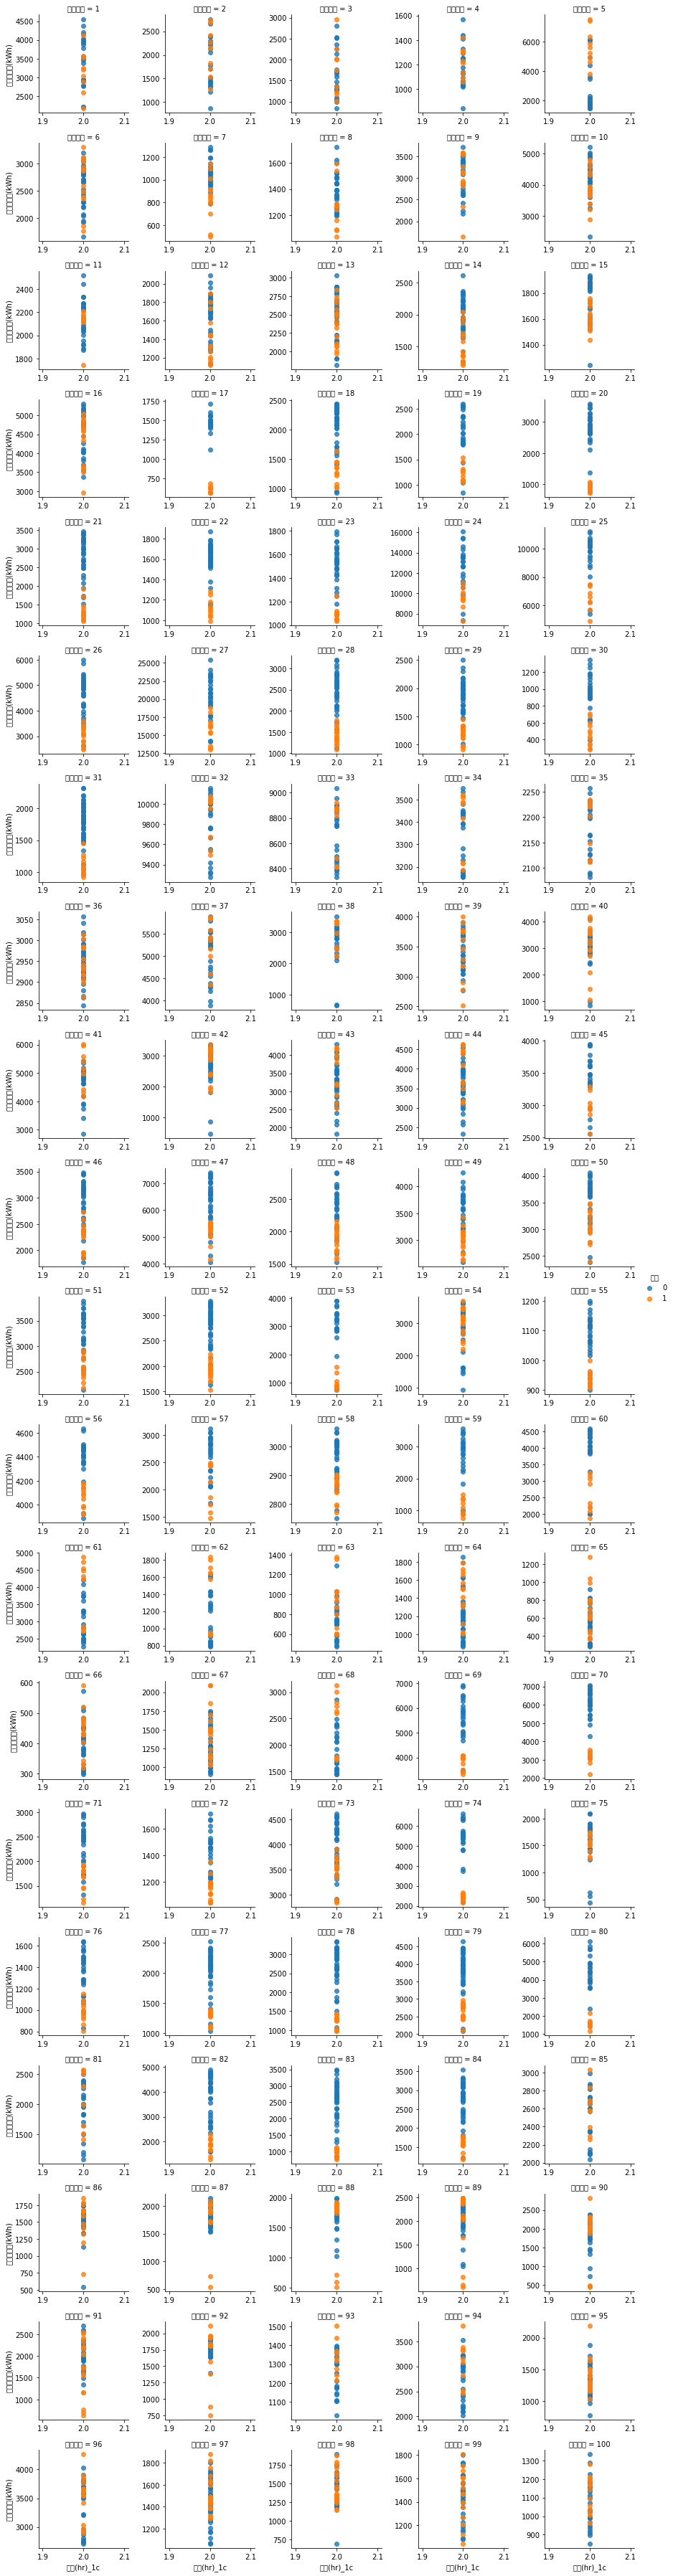

In [202]:
solar_df['주말'] = solar_df['요일'].isin([5, 6]).astype(int)

df = solar_df.groupby(['건물번호','주말','날짜'])['일조(hr)','전력소비량(kWh)'].mean().reset_index()

df['일조(hr)_1b'] = df['일조(hr)'].shift(1)
df['일조(hr)_2b'] = df['일조(hr)'].shift(2)
df['일조(hr)_3b'] = df['일조(hr)'].shift(3)
df['일조(hr)_1c'] = df['일조(hr)'] + df['일조(hr)_1b']
df['일조(hr)_2c'] = df['일조(hr)'] + df['일조(hr)_1b'] + df['일조(hr)_2b']
df['일조(hr)_3c'] = df['일조(hr)'] + df['일조(hr)_1b'] + df['일조(hr)_2b'] + df['일조(hr)_3b']

fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = df, x = '일조(hr)_1c', y = '전력소비량(kWh)', hue = '주말', col = '건물번호', height = 2.5, aspect = 1,
          col_wrap = 5, sharey = False, sharex = False)

In [203]:
df

건물번호  주말          날짜  일조(hr)   전력소비량(kWh)  일조(hr)_1b  일조(hr)_2b  \
0        1   0  2022-06-01     1.0  2341.920000        NaN        NaN   
1        1   0  2022-06-02     1.0  2939.253333        1.0        NaN   
2        1   0  2022-06-03     1.0  3384.660000        1.0        1.0   
3        1   0  2022-06-06     1.0  2217.600000        1.0        1.0   
4        1   0  2022-06-07     1.0  2773.080000        1.0        1.0   
...    ...  ..         ...     ...          ...        ...        ...   
4339   100   1  2022-07-17     1.0  1054.800000        1.0        1.0   
4340   100   1  2022-07-30     1.0  1210.160000        1.0        1.0   
4341   100   1  2022-08-06     1.0  1144.320000        1.0        1.0   
4342   100   1  2022-08-20     1.0  1187.880000        1.0        1.0   
4343   100   1  2022-08-21     1.0  1206.000000        1.0        1.0   

      일조(hr)_3b  일조(hr)_1c  일조(hr)_2c  일조(hr)_3c  
0           NaN        NaN        NaN        NaN  
1           NaN        2.0        NaN        NaN  
2           NaN        2.0        3.0        NaN  
3           1.0        2.0        3.0        4.0  
4           1.0        2.0        3.0        4.0  
...         ...        ...        ...        ...  
4339        1.0        2.0        3.0        4.0  
4340        1.0        2.0        3.0        4.0  
4341        1.0        2.0        3.0        4.0  
4342        1.0        2.0        3.0        4.0  
4343        1.0        2.0        3.0        4.0  

[4344 rows x 11 columns]

c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0, flags=flags)


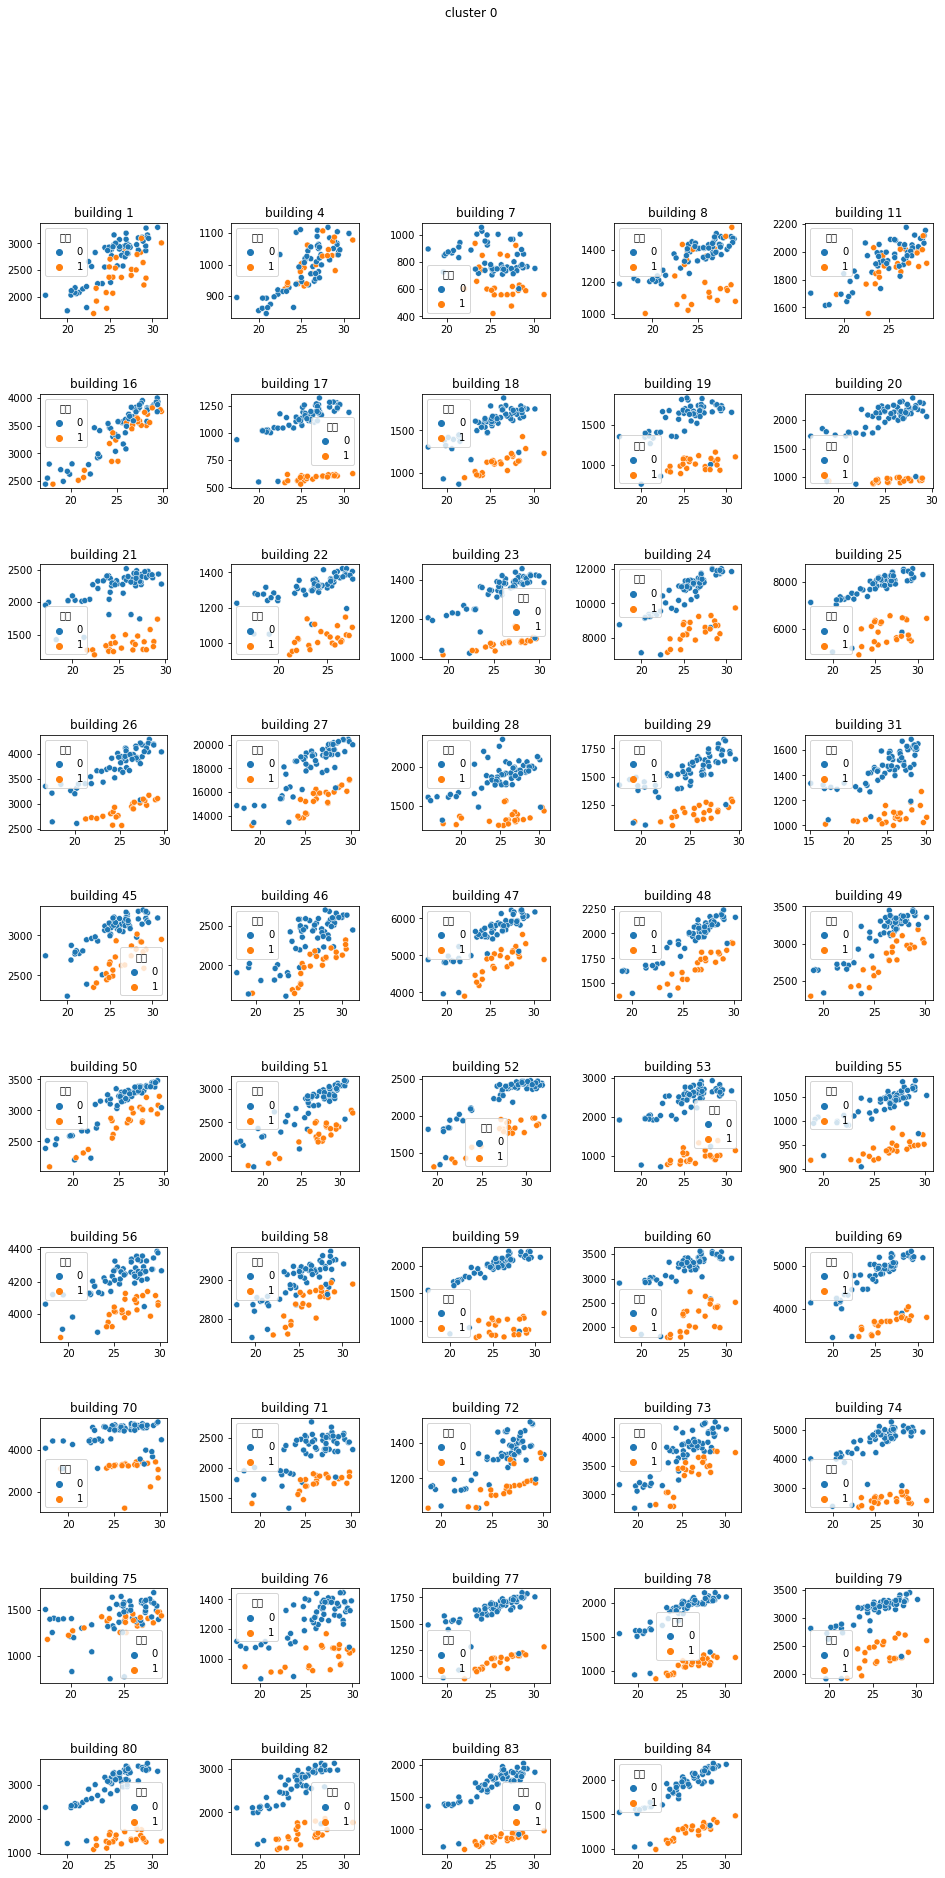

<Figure size 1152x288 with 0 Axes>

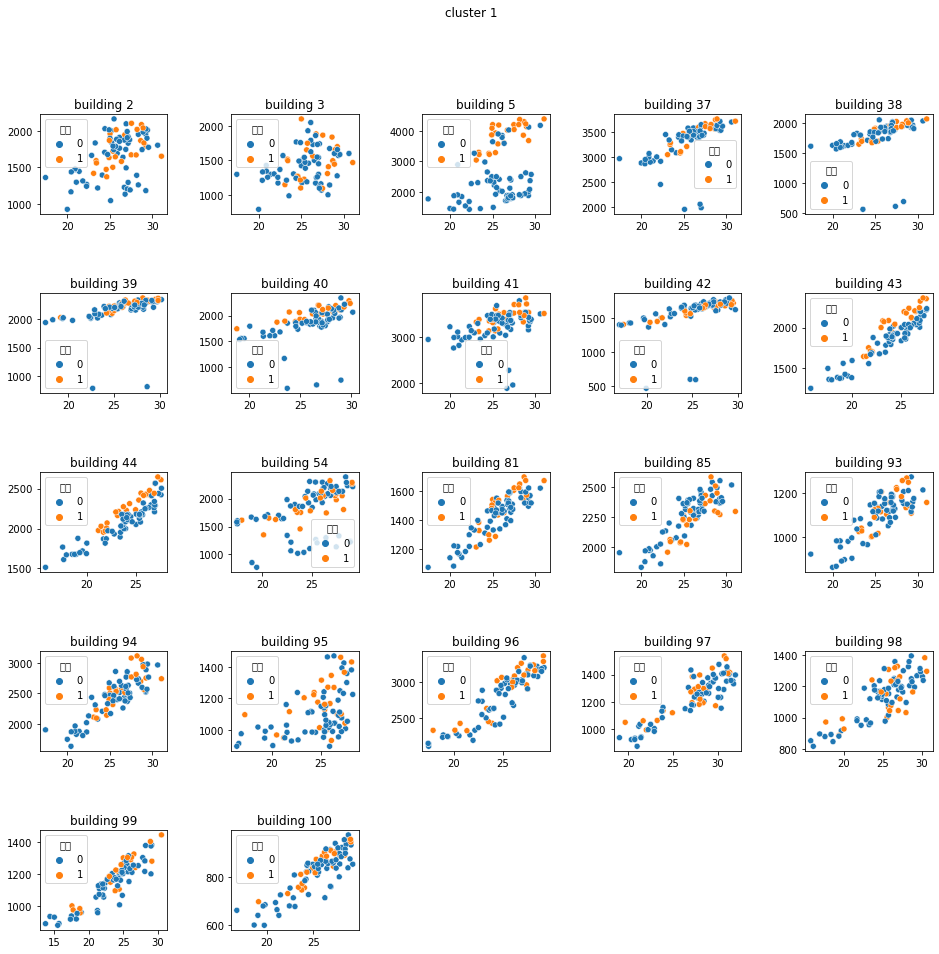

<Figure size 1152x576 with 0 Axes>

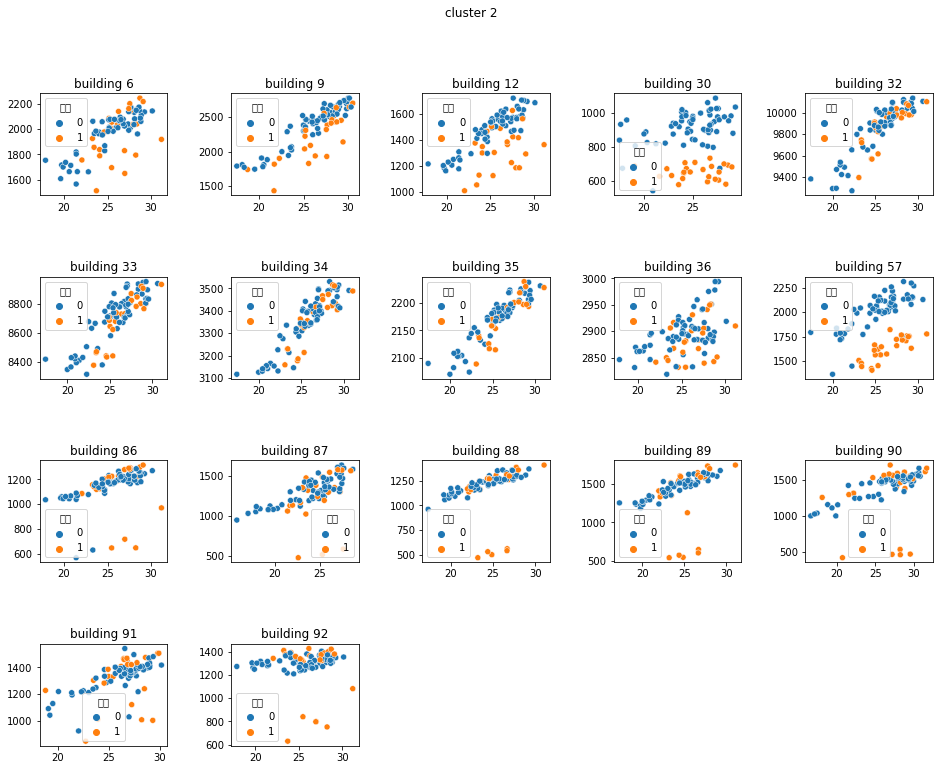

<Figure size 1152x2160 with 0 Axes>

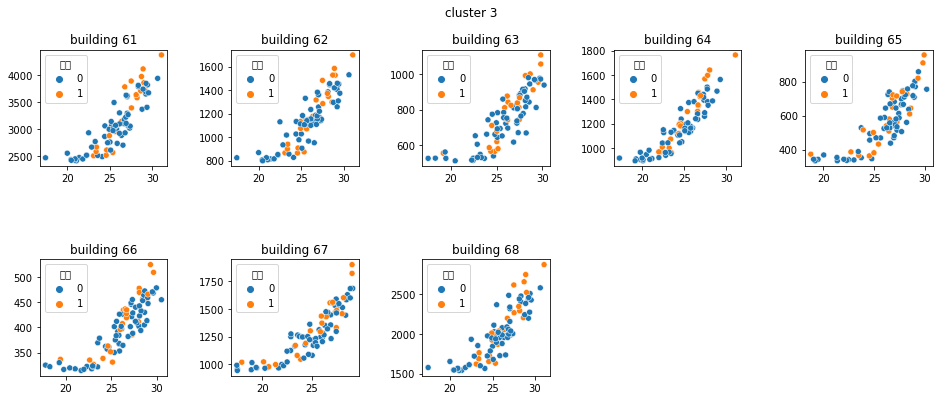

<Figure size 1152x2448 with 0 Axes>

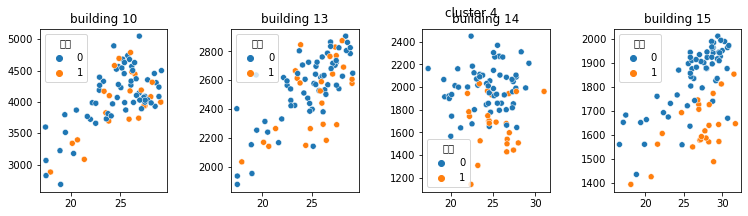

In [208]:
# 날짜별로 일평균 기온과 일평균 전력 사용량의 상관관계 파악
eda_df['주말'] = eda_df['요일'].isin([5, 6]).astype(int)

temp_1 = eda_df[eda_df.km_cluster == 0]
nums = np.unique(temp_1.건물번호)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 0')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.건물번호 == num]
    temp_2 = temp_2.groupby(['건물번호','날짜','주말'])[['전력소비량(kWh)','기온(C)']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온(C)', y='전력소비량(kWh)', hue= '주말')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.8)
    
fig = plt.figure(figsize = (16, 4))
temp_1 = eda_df[eda_df.km_cluster == 1]
nums = np.unique(temp_1.건물번호)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 1')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.건물번호 == num]
    temp_2 = temp_2.groupby(['건물번호','날짜','주말'])[['전력소비량(kWh)','기온(C)']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온(C)', y='전력소비량(kWh)', hue= '주말')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.8)

fig = plt.figure(figsize = (16, 8))
temp_1 = eda_df[eda_df.km_cluster == 2]
nums = np.unique(temp_1.건물번호)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 2')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.건물번호 == num]
    temp_2 = temp_2.groupby(['건물번호','날짜','주말'])[['전력소비량(kWh)','기온(C)']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온(C)', y='전력소비량(kWh)', hue= '주말')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.8)

fig = plt.figure(figsize = (16, 30))
temp_1 = eda_df[eda_df.km_cluster == 3]
nums = np.unique(temp_1.건물번호)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 3')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.건물번호 == num]
    temp_2 = temp_2.groupby(['건물번호','날짜','주말'])[['전력소비량(kWh)','기온(C)']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온(C)', y='전력소비량(kWh)', hue= '주말')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.8)

fig = plt.figure(figsize = (16, 34))
temp_1 = eda_df[eda_df.km_cluster == 4]
nums = np.unique(temp_1.건물번호)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 4')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.건물번호 == num]
    temp_2 = temp_2.groupby(['건물번호','날짜','주말'])[['전력소비량(kWh)','기온(C)']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='기온(C)', y='전력소비량(kWh)', hue= '주말')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)